## Marketing channel classification model
마케팅 채널 A와 B를 구분할 수 있는 **채널 분류 모델**  

타겟변수가 marketing_channel로 categorical variable이고, A와 B 두 가지로 분류되는 **binary classification** 문제이다.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
import datetime
from collections import Counter

In [2]:
user_info = pd.read_csv('user_info.csv')
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445220 entries, 0 to 445219
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_uuid          445220 non-null  object 
 1   marketing_channel  445220 non-null  object 
 2   sex                445220 non-null  object 
 3   age_group          436109 non-null  object 
 4   date_joined        445220 non-null  object 
 5   os                 445220 non-null  object 
 6   visits             405085 non-null  float64
 7   revenue            405085 non-null  float64
dtypes: float64(2), object(6)
memory usage: 27.2+ MB


결측치 처리를 하기 위해 우선 결측치의 패턴을 확인해야 한다.  
결측치는 세 개의 변수에 집중되어 있고, age_group의 약 2%, visits와 revenue의 9%를 차지한다.

In [3]:
user_info = user_info.drop(['user_uuid'], axis=1) #unnecessary column
user_info.isnull().sum()
user_info.isnull().sum() / len(user_info) #explore missing data

marketing_channel    0.000000
sex                  0.000000
age_group            0.020464
date_joined          0.000000
os                   0.000000
visits               0.090146
revenue              0.090146
dtype: float64

결측치를 시각화해보면 age_group의 결측치는 완전 무작위 결측으로 보이고, visits와 revenue의 결측치는 서로 연관되어 있지만 비관측된 다른 변수들과는 무관한 무작위 결측으로 판단된다.

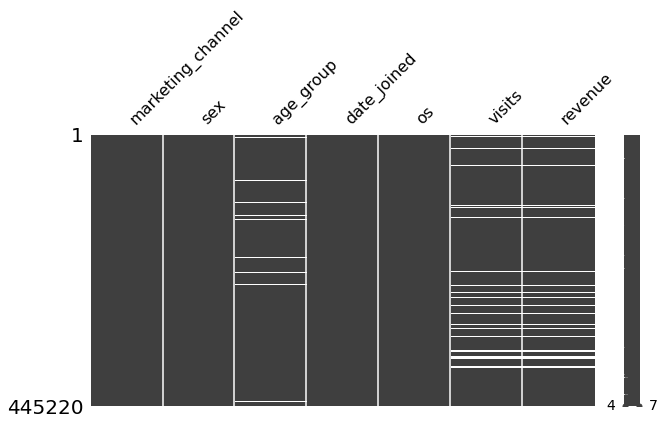

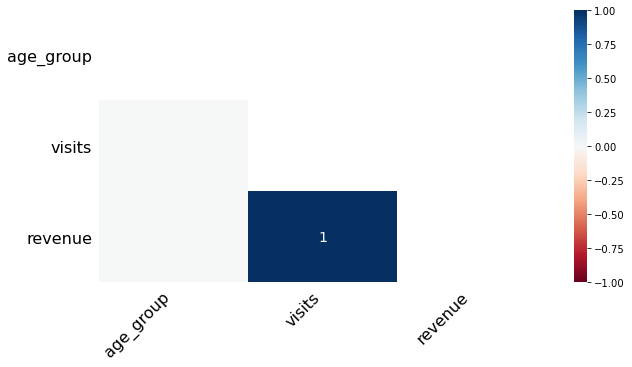

In [4]:
msno.matrix(user_info, figsize=(10, 5))
msno.heatmap(user_info, figsize=(10, 5))
plt.show()

age_group의 결측치는 완전 무작위 결측이며 2%로 매우 적으므로 제거한다.  
visits와 revenue의 결측치는 의미상으로 '회원가입 후 한번도 방문하지 않고 매출이 발생하지 않은 사용자'를 뜻하므로, 0으로 대체하는 것이 합리적이다.

In [5]:
user_info.dropna(subset=['age_group'], axis=0, inplace=True)
user_info.fillna({'visits':0, 'revenue':0}, inplace=True)
user_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 436109 entries, 0 to 445219
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   marketing_channel  436109 non-null  object 
 1   sex                436109 non-null  object 
 2   age_group          436109 non-null  object 
 3   date_joined        436109 non-null  object 
 4   os                 436109 non-null  object 
 5   visits             436109 non-null  float64
 6   revenue            436109 non-null  float64
dtypes: float64(2), object(5)
memory usage: 26.6+ MB


다음으로, 이상치를 판단하는데 가입기간을 고려하기 위해 새로운 column을 만들었다.  
period column은 date_joined를 기준으로 데이터 추출 시점까지의 기간(일)으로 정의한다.

In [6]:
data_extraction_date = datetime.datetime(2030, 12, 31)
user_info['period'] = user_info['date_joined'].apply(lambda x: (data_extraction_date - pd.to_datetime(x)).days)

Numerical features 중에 이상치를 제거하기 위해 IQR rule을 사용하였다.  
단순히 IQR rule을 사용해서 이상치로 분류되는 데이터를 모두 제거하기보다, 해당 feature의 대표 통계량과 boxplot을 종합적으로 판단하여 이상치를 처리하였다.

In [7]:
def detect_outlier(df, n, features):
  outlier_indices = []
  for col in features:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1
    outlier_range = 1.5 * IQR
    outlier_col = df[(df[col] < Q1 - outlier_range) | (df[col] > Q3 + outlier_range)].index
    outlier_indices.extend(outlier_col)
  outlier_indices = Counter(outlier_indices)
  outliers = list(k for k, v in outlier_indices.items() if v >= n)
  return outliers

먼저 visits의 경우는 평균이 9.2이고 표준편차가 9.6이므로 대략 0 ~ 19 사이에 68%의 데이터가 존재한다.  
가입한 사용자 중 앱을 한번도 방문하지 않은 경우는 충분히 존재할 수 있으므로, 방문 수가 극단적으로 많은 경우만 이상치로 간주하는 것이 합리적이다.  
계산된 이상치의 수는 19,170개인데, 이들 중 일부를 살펴보았을 때 정상적인 값으로 판단되는 데이터가 다수 존재한다.  
예를 들어, period가 200일 이상으로 충분히 긴 경우라면 30회 이상의 방문 수가 발생할 가능성이 있으므로 이상치로 보기 어렵다.

count    436109.000000
mean          9.224020
std           9.558176
min           0.000000
25%           2.000000
50%           6.000000
75%          13.000000
max         172.000000
Name: visits, dtype: float64


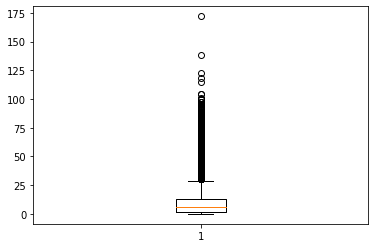

num. of outliers in visits:  19170
   marketing_channel     sex age_group date_joined       os  visits  revenue  \
19         channel_A  female     20-29  2030-05-10  android    32.0    135.0   
20         channel_A  female     30-39  2030-05-02  android    42.0    222.0   
37         channel_A    male     30-39  2030-05-12  android    31.0    329.0   
67         channel_A  female     30-39  2030-05-21  android    46.0     80.0   
91         channel_A  female     20-29  2030-05-12      iOS    30.0     40.0   

    period  
19     235  
20     243  
37     233  
67     224  
91     233  


In [8]:
print(user_info['visits'].describe())
plt.boxplot(user_info['visits'])
plt.show()

outlier_visits_calc = detect_outlier(user_info, 1, ['visits'])
print('num. of outliers in visits: ', len(outlier_visits_calc))
print(user_info.loc[outlier_visits_calc].head())

위의 계산된 이상치들 중 초반 데이터(visits이 30 ~ 40 이고 period가 220 ~ 240)들은 period-visits scatter plot에서는 전혀 이상치로 보이지 않는다.   
scatter plot에서 period와 관계없이 visits이 0인 경우는 충분히 발생할 수 있으므로 이상치로 처리하지 않는다.  
그러나 period가 짧은데 visits이 극단적으로 많이 나온 경우는 이상치로 볼 수 있으므로, 해당 데이터는 제거해준다.  

(436108, 8)

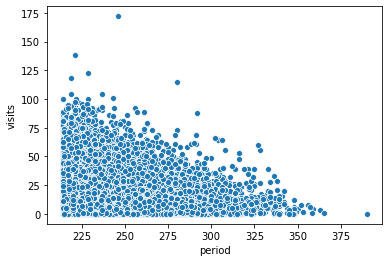

In [9]:
sns.scatterplot(x='period', y='visits', data=user_info)
outlier_visits_drop = user_info[(user_info['period'] < 300) & (user_info['visits'] > 170)].index
user_info = user_info.drop(outlier_visits_drop, axis=0)
user_info.shape

revenue의 경우는 평균이 170.7이고 표준편차가 167.6이므로 대략 3 ~ 340 사이에 68%의 데이터가 존재한다.  
마찬가지로 앱을 한번도 방문하지 않은 사용자는 revenue도 0일 것이므로, revenue가 극단적으로 큰 경우만 이상치로 고려하였다.  
계산된 이상치의 수는 23,939개이다.

count    436108.000000
mean        170.713825
std         167.627040
min           0.000000
25%          67.000000
50%         129.000000
75%         223.000000
max        4623.000000
Name: revenue, dtype: float64


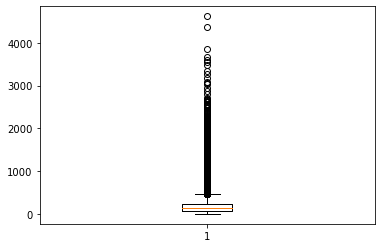

num. of outliers in revenue:  23939
   marketing_channel     sex age_group date_joined       os  visits  revenue  \
5          channel_A  female     40-49  2030-04-24  android     1.0    906.0   
9          channel_B  female     50-59  2030-05-13  android     4.0    825.0   
12         channel_A  female     30-39  2030-05-12  android     8.0    517.0   
27         channel_A    male     50-59  2030-05-30      iOS     2.0    479.0   
42         channel_A  female     30-39  2030-05-29      iOS     6.0    680.0   

    period  
5      251  
9      232  
12     233  
27     215  
42     216  


In [10]:
print(user_info['revenue'].describe())
plt.boxplot(user_info['revenue'])
plt.show()

outlier_revenue_calc = detect_outlier(user_info, 1, ['revenue'])
print('num. of outliers in revenue: ', len(outlier_revenue_calc))
print(user_info.loc[outlier_revenue_calc].head())

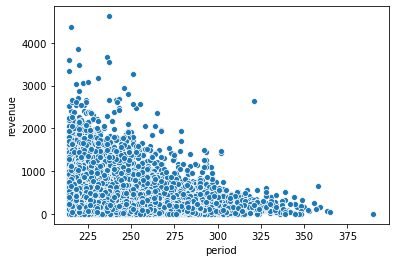

In [11]:
sns.scatterplot(x='period', y='revenue', data=user_info)

대신 basket size를 구하여 visits 대비 revenue가 극단적으로 큰 데이터를 이상치로 판단하였다.  
user_info에 basket_size column을 추가하여 boxplot을 그려 2000 이상인 이상치를 제거하였다.

count    436108.000000
mean         42.341820
std          77.638738
min           0.000000
25%           6.461538
50%          17.333328
75%          44.749989
max        4622.995377
Name: basket_size, dtype: float64


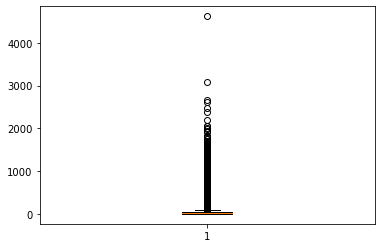

num. of outliers in basket_size:  45036
   marketing_channel     sex age_group date_joined       os  visits  revenue  \
5          channel_A  female     40-49  2030-04-24  android     1.0    906.0   
9          channel_B  female     50-59  2030-05-13  android     4.0    825.0   
17         channel_A    male     30-39  2030-04-15  android     1.0    108.0   
27         channel_A    male     50-59  2030-05-30      iOS     2.0    479.0   
34         channel_B    male       -99  2030-05-25  android     2.0    268.0   

    period  basket_size  
5      251   905.999094  
9      232   206.249948  
17     260   107.999892  
27     215   239.499880  
34     220   133.999933  


In [12]:
def rev_per_vis(x):
  return x['revenue']/(x['visits'] + 0.000001)

user_info['basket_size'] = user_info.apply(rev_per_vis, axis=1)
print(user_info['basket_size'].describe())
plt.boxplot(user_info['basket_size'])
plt.show()

outlier_basket_size_calc = detect_outlier(user_info, 1, ['basket_size'])
print('num. of outliers in basket_size: ', len(outlier_basket_size_calc))
print(user_info.loc[outlier_basket_size_calc].head())

(436098, 9)


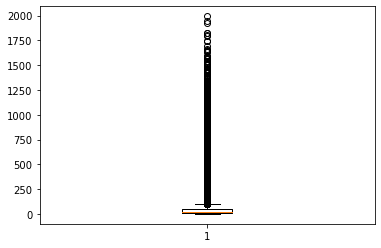

In [13]:
outlier_basket_size_drop = user_info[(user_info['basket_size'] > 2000)].index
user_info = user_info.drop(outlier_basket_size_drop, axis=0)
print(user_info.shape)
plt.boxplot(user_info['basket_size'])
plt.show()

In [14]:
user_info.to_csv('user_info_preprocessed.csv', index=False)

In [15]:
user_info = pd.read_csv('user_info_preprocessed.csv')
user_info = user_info.drop(['date_joined'], axis=1) #used as period
user_info.head()

,marketing_channel,sex,age_group,os,visits,revenue,period,basket_size
0,channel_A,male,30-39,android,23.0,304.0,235,13.217391
1,channel_B,male,20-29,android,5.0,195.0,235,38.999992
2,channel_A,male,30-39,android,1.0,78.0,220,77.999922
3,channel_A,female,30-39,iOS,18.0,202.0,225,11.222222
4,channel_A,male,30-39,android,9.0,197.0,225,21.888886


설명변수별 타겟변수와의 관계를 시각화해보면, 타겟변수를 두 그룹으로 분류할 가능성이 높은 설명변수가 두드러지게 나타나지 않는다.  
즉, 모든 변수들에 대해 Channel A와 B라는 라벨이 고르게 분포한다.

(436098, 7) (436098,)


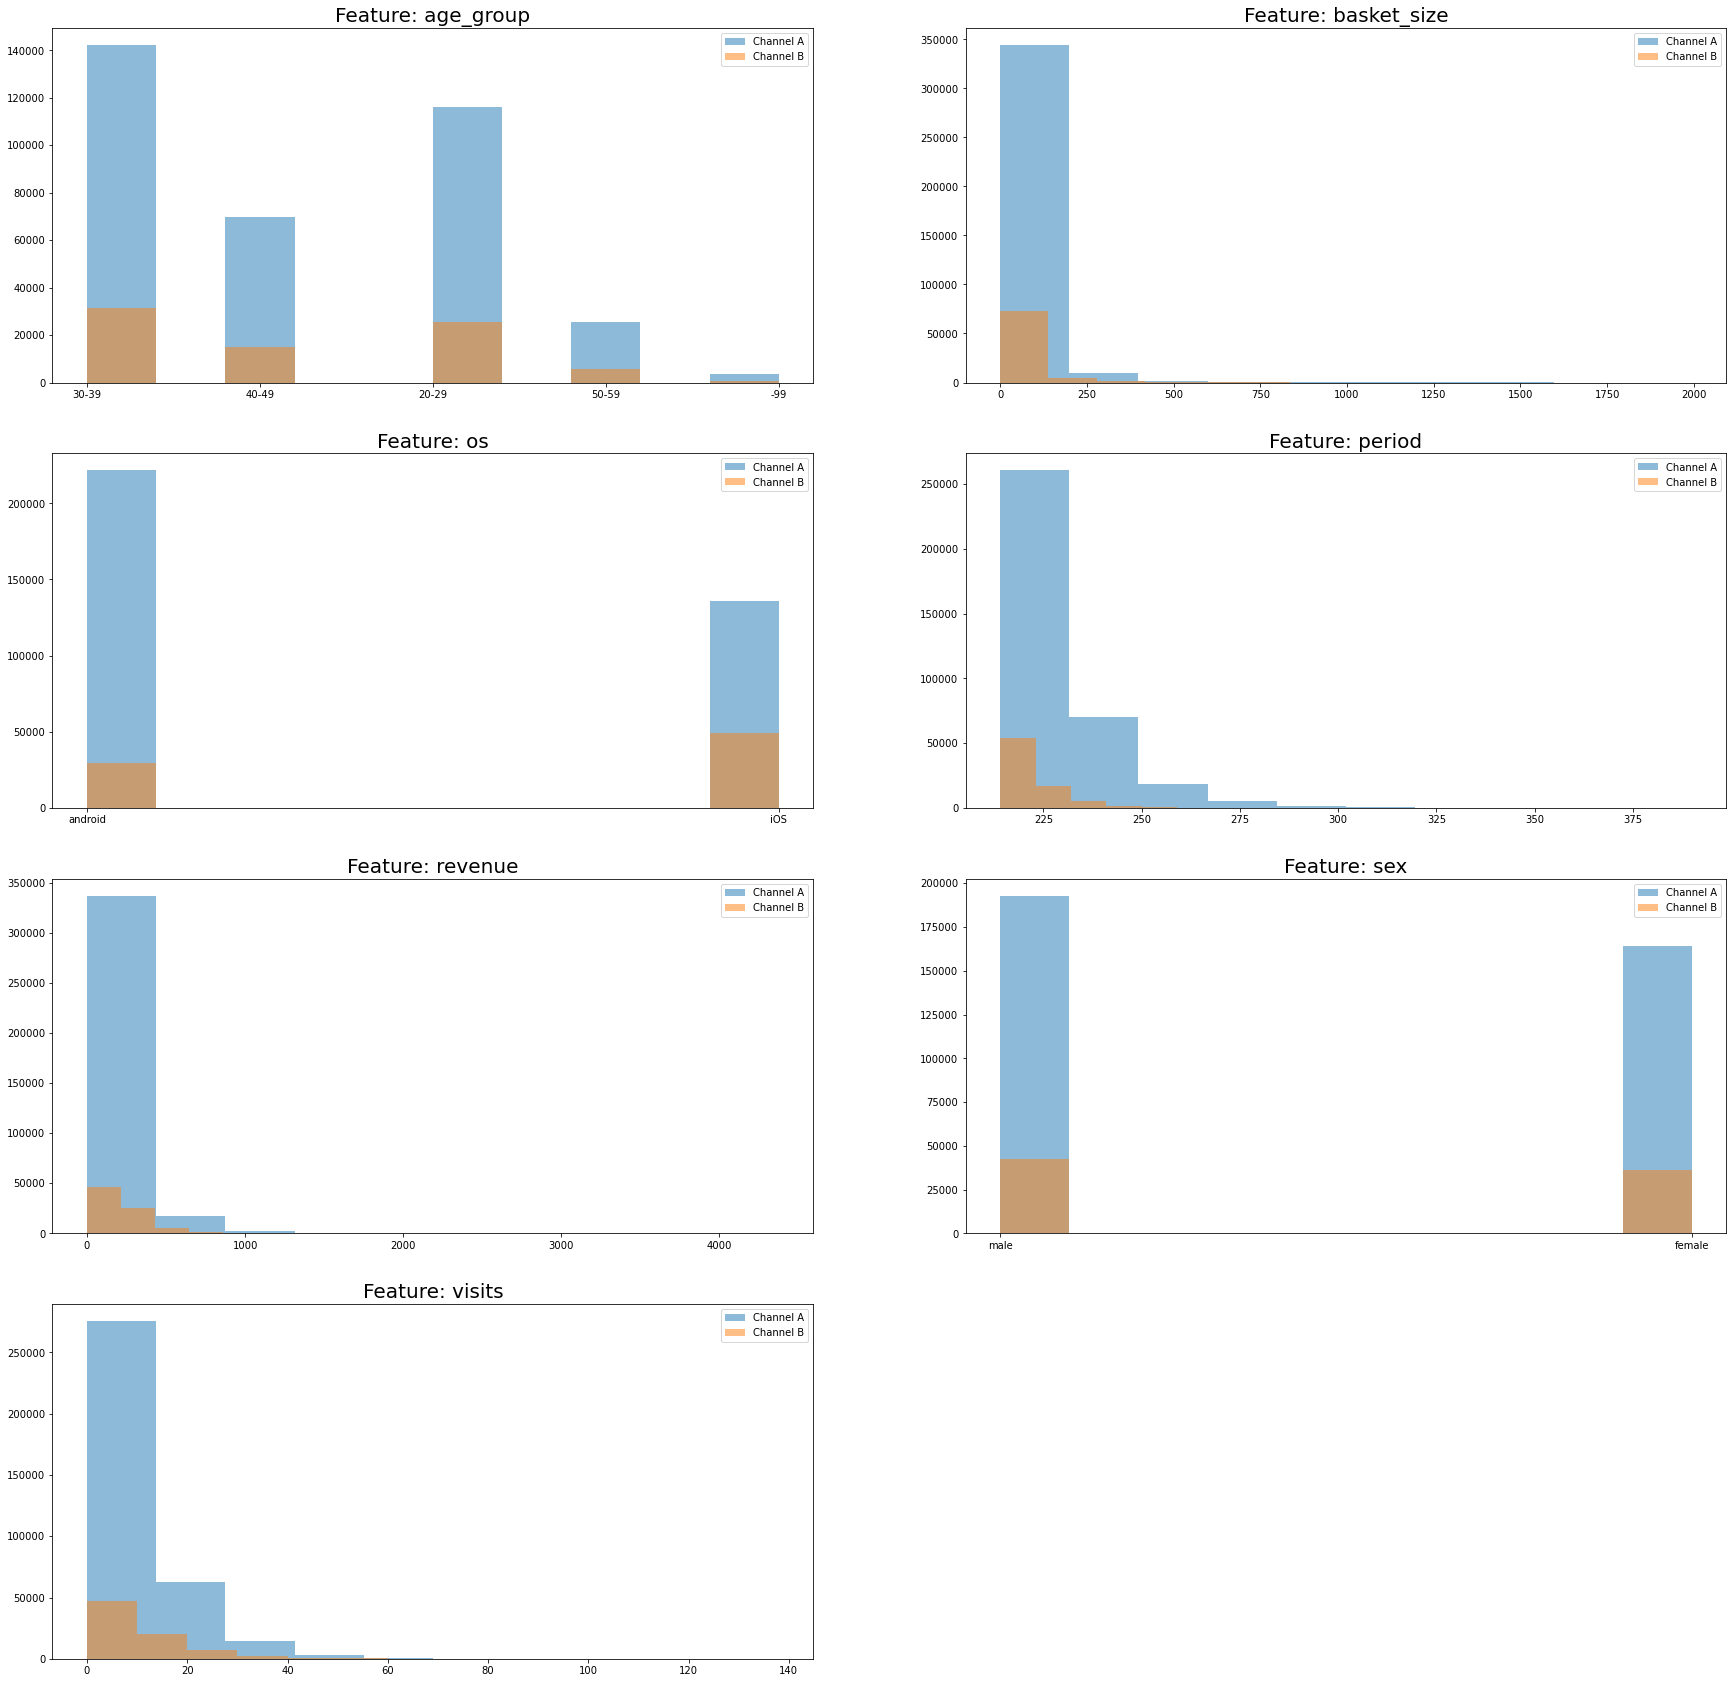

In [16]:
x = user_info[user_info.columns.difference(['marketing_channel'])]
feature_name = x.columns
y = user_info['marketing_channel']
print(x.shape, y.shape)

plt.figure(figsize=(30, 30))
for col_idx in range(len(feature_name)):
    plt.subplot(4, 2, col_idx + 1)
    plt.hist(user_info[user_info['marketing_channel'] == 'channel_A'][feature_name[col_idx]], label='Channel A', alpha=0.5)
    plt.hist(user_info[user_info['marketing_channel'] == 'channel_B'][feature_name[col_idx]], label='Channel B', alpha=0.5)
    plt.legend()
    plt.title("Feature: " + feature_name[col_idx], fontsize=20)
plt.show()

In [17]:
num_feats = x.dtypes[x.dtypes != 'object'].index
cat_feats = x.dtypes[x.dtypes == 'object'].index

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x[num_feats]) #data scaling numerical features

In [19]:
for cat in list(cat_feats):
    print(x[cat].value_counts())
    print('-'*50)
x_dummy = pd.get_dummies(x, columns=cat_feats) #convert categorical features into dummy variables
x_rev = np.concatenate((x_scaled, x_dummy), axis=1) #merge with scaled numerical features
print(x_rev.shape)

30-39    173709
20-29    141862
40-49     84775
50-59     31224
-99        4528
Name: age_group, dtype: int64
--------------------------------------------------
android    251473
iOS        184625
Name: os, dtype: int64
--------------------------------------------------
male      235477
female    200621
Name: sex, dtype: int64
--------------------------------------------------
(436098, 17)


In [20]:
y_a = (y == 'channel_A')
y_a.value_counts(normalize=True) #convert target as boolean (channel_A == 1)

True     0.819325
False    0.180675
Name: marketing_channel, dtype: float64

Channel A와 B가 비대칭하게 분포하는 데이터셋이므로, 타겟값의 분포가 training set과 test set에 비슷한 비율로 추출되었는지 확인해야한다.

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_rev, y_a, test_size = 0.2, random_state = 1)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

True     0.819014
False    0.180986
Name: marketing_channel, dtype: float64
True     0.820569
False    0.179431
Name: marketing_channel, dtype: float64


여러 분류 모델의 성능을 비교하여 적절한 모델을 선택한다.  
이 과정에서 cross validation을 사용하는데, 클래스가 비대칭한 데이터셋이므로 층화추출(stratified)을 쓴다.

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold 

skfold = StratifiedKFold(n_splits=3, shuffle = True, random_state=42) 

def display_scores(model_name, score):
    print('Model: ', model_name)
    print('Scores: ', score)
    print('Mean score: ', score.mean())

In [23]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=1)
sgd.fit(x_train, y_train)
score_sgd = cross_val_score(sgd, x_train, y_train, cv=skfold, scoring='accuracy')
display_scores('SGD classifier', score_sgd)

Model:  SGD classifier
Scores:  [0.8188713  0.81900888 0.81901593]
Mean score:  0.8189653691277647


In [24]:
from sklearn.tree import DecisionTreeClassifier as DTC
tree = DTC(criterion='entropy')
tree.fit(x_train, y_train)
score_tree = cross_val_score(tree, x_train, y_train, cv=skfold, scoring='accuracy')
display_scores('Decision tree', score_tree)

Model:  Decision tree
Scores:  [0.74150637 0.74172994 0.74106559]
Mean score:  0.741433967265423


In [25]:
from sklearn.ensemble import RandomForestClassifier as RFC
forest = RFC(criterion='gini', n_estimators=350, n_jobs=4)
forest.fit(x_train, y_train)
score_forest = cross_val_score(forest, x_train, y_train, cv=skfold, scoring='accuracy')
display_scores('Random forest', score_forest)

Model:  Random forest
Scores:  [0.79660857 0.79767484 0.79644344]
Mean score:  0.7969089467793576


In [26]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
score_knn = cross_val_score(knn, x_train, y_train, cv=skfold, scoring='accuracy')
display_scores('KNN', score_knn)

Model:  KNN
Scores:  [0.79351294 0.79368492 0.79349396]
Mean score:  0.7935639390561297


In [27]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=500, random_state=1)
xgb.fit(x_train, y_train)
score_xgb = cross_val_score(xgb, x_train, y_train, cv=skfold, scoring='accuracy')
display_scores('XGBoost', score_xgb)

C:\Users\CSD\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:32:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\CSD\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:33:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model:  XGBoost
Scores:  [0.81624861 0.81695373 0.81638462]
Mean score:  0.81652898679662


In [28]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=500, random_state=1)
lgbm.fit(x_train, y_train)
score_lgbm = cross_val_score(lgbm, x_train, y_train, cv=skfold, scoring='accuracy')
display_scores('LightGBM', score_lgbm)

Model:  LightGBM
Scores:  [0.81986018 0.82025573 0.81865477]
Mean score:  0.8195902265678519


위 모델들 중에 정확도가 가장 높은 LightGBM 모델을 선택하여, hyperparameter tuning을 하였다.

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import time

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 1)

분류모델이므로 성능 지표로 confusion matrix의 accuracy, precision, recall, f1, roc-auc 를 사용한다.

In [30]:
#before tuning
tic = time.time()

lgbm_before = LGBMClassifier(learning_rate=0.1, n_estimators=100,
                             objective= 'binary', seed=27)
lgbm_before.fit(x_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train, y_train), (x_val, y_val)])

y_pred = lgbm_before.predict(x_val)
y_pred_proba = lgbm_before.predict_proba(x_val)[:,1]

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
lgbm_roc_score = roc_auc_score(y_val, y_pred_proba, average='macro')
toc = time.time()

print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
print('time elapsed:', toc - tic)

[1]	training's auc: 0.753097	training's binary_logloss: 0.460474	valid_1's auc: 0.757114	valid_1's binary_logloss: 0.462786

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[2]	training's auc: 0.755685	training's binary_logloss: 0.451182	valid_1's auc: 0.759194	valid_1's binary_logloss: 0.453245
[3]	training's auc: 0.756869	training's binary_logloss: 0.443776	valid_1's auc: 0.760424	valid_1's binary_logloss: 0.445621
[4]	training's auc: 0.757623	training's binary_logloss: 0.437728	valid_1's auc: 0.760898	valid_1's binary_logloss: 0.439421
[5]	training's auc: 0.758635	training's binary_logloss: 0.432722	valid_1's auc: 0.762181	valid_1's binary_logloss: 0.434235
[6]	training's auc: 0.758937	training's binary_logloss: 0.428576	valid_1's auc: 0.762605	valid_1's binary_logloss: 0.429925
[7]	training's auc: 0.759438	training's binary_logloss: 0.425101	valid_1's auc: 0.763079	valid_1's binary_logloss: 0.426343
[8]	training's auc: 0.759741	training's binary_logloss: 0.422187	valid_1's auc: 0.763359	valid_1's binary_logloss: 0.423312
[9]	training's auc: 0.760053	training's binary_logloss: 0.419732	valid_1's auc: 0.763604	valid_1's binary_logloss: 0.420771
[10]	tr

max_depth, num_leaves, min_child_samples 순으로 hyperparameter tuning을 진행한다.

In [31]:
tic = time.time()
lgbm = LGBMClassifier(learning_rate=0.1, n_estimators=100,
                     objective= 'binary', seed=27)
param_1 = {'max_depth':range(10,31)}
gridcv = GridSearchCV(lgbm, param_grid=param_1, cv=3)
gridcv.fit(x_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train, y_train), (x_val, y_val)])

y_pred = gridcv.predict(x_val)
y_pred_proba = gridcv.predict_proba(x_val)[:,1]

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
lgbm_roc_score = roc_auc_score(y_val, y_pred_proba, average='macro')
toc = time.time()

print(gridcv.best_params_)
print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
print('time elapsed:', toc - tic)

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753138	valid_0's binary_logloss: 0.460441	valid_1's auc: 0.757238	valid_1's binary_logloss: 0.462743
[2]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.451163	valid_1's auc: 0.759271	valid_1's binary_logloss: 0.453175
[3]	valid_0's auc: 0.756579	valid_0's binary_logloss: 0.443753	valid_1's auc: 0.760217	valid_1's binary_logloss: 0.445563
[4]	valid_0's auc: 0.757493	valid_0's binary_logloss: 0.437684	valid_1's auc: 0.761609	valid_1's binary_logloss: 0.439263
[5]	valid_0's auc: 0.758013	valid_0's binary_logloss: 0.432704	valid_1's auc: 0.762094	valid_1's binary_logloss: 0.434108
[6]	valid_0's auc: 0.758507	valid_0's binary_logloss: 0.428559	valid_1's auc: 0.762334	valid_1's binary_logloss: 0.429857
[7]	valid_0's auc: 0.759121	valid_0's binary_logloss: 0.425125	valid_1's auc: 0.762828	valid_1's binary_logloss: 0.426298
[8]	valid_0's auc: 0.759531	valid_0's binary_logloss: 0.422179	valid_1's auc: 0.763332	valid_1's binary_logloss: 0.423236
[9]	valid_0's auc: 0.759

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753338	valid_0's binary_logloss: 0.460459	valid_1's auc: 0.756568	valid_1's binary_logloss: 0.462795
[2]	valid_0's auc: 0.755277	valid_0's binary_logloss: 0.451171	valid_1's auc: 0.758492	valid_1's binary_logloss: 0.453242
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443772	valid_1's auc: 0.759494	valid_1's binary_logloss: 0.445626
[4]	valid_0's auc: 0.756967	valid_0's binary_logloss: 0.437725	valid_1's auc: 0.760451	valid_1's binary_logloss: 0.439365
[5]	valid_0's auc: 0.757609	valid_0's binary_logloss: 0.432755	valid_1's auc: 0.76124	valid_1's binary_logloss: 0.43421
[6]	valid_0's auc: 0.758463	valid_0's binary_logloss: 0.428587	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.4299
[7]	valid_0's auc: 0.759048	valid_0's binary_logloss: 0.425101	valid_1's auc: 0.762714	valid_1's binary_logloss: 0.426288
[8]	valid_0's auc: 0.759523	valid_0's binary_logloss: 0.422166	valid_1's auc: 0.76313	valid_1's binary_logloss: 0.423256
[9]	valid_0's auc: 0.759902	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752866	valid_0's binary_logloss: 0.460448	valid_1's auc: 0.756467	valid_1's binary_logloss: 0.462794
[2]	valid_0's auc: 0.75536	valid_0's binary_logloss: 0.451179	valid_1's auc: 0.758945	valid_1's binary_logloss: 0.453254
[3]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.443778	valid_1's auc: 0.760691	valid_1's binary_logloss: 0.44564
[4]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.437714	valid_1's auc: 0.76193	valid_1's binary_logloss: 0.43937
[5]	valid_0's auc: 0.758428	valid_0's binary_logloss: 0.432739	valid_1's auc: 0.762169	valid_1's binary_logloss: 0.43425
[6]	valid_0's auc: 0.759008	valid_0's binary_logloss: 0.428583	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.429974
[7]	valid_0's auc: 0.75927	valid_0's binary_logloss: 0.425109	valid_1's auc: 0.762876	valid_1's binary_logloss: 0.426393
[8]	valid_0's auc: 0.75948	valid_0's binary_logloss: 0.422226	valid_1's auc: 0.763083	valid_1's binary_logloss: 0.423397
[9]	valid_0's auc: 0.759727	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's auc: 0.753097	training's binary_logloss: 0.460474	valid_1's auc: 0.757114	valid_1's binary_logloss: 0.462786
[2]	training's auc: 0.755685	training's binary_logloss: 0.451182	valid_1's auc: 0.759194	valid_1's binary_logloss: 0.453245
[3]	training's auc: 0.756869	training's binary_logloss: 0.443776	valid_1's auc: 0.760424	valid_1's binary_logloss: 0.445621
[4]	training's auc: 0.757623	training's binary_logloss: 0.437728	valid_1's auc: 0.760898	valid_1's binary_logloss: 0.439421
[5]	training's auc: 0.758635	training's binary_logloss: 0.432722	valid_1's auc: 0.762181	valid_1's binary_logloss: 0.434235
[6]	training's auc: 0.758937	training's binary_logloss: 0.428576	valid_1's auc: 0.762605	valid_1's binary_logloss: 0.429925
[7]	training's auc: 0.759438	training's binary_logloss: 0.425101	valid_1's auc: 0.763079	valid_1's binary_logloss: 0.426343
[8]	training's auc: 0.759741	training's binary_logloss: 0.422187	valid_1's auc: 0.763359	valid_1's binary_logloss: 0.423312
[9]	trai

In [32]:
tic = time.time()
lgbm = LGBMClassifier(learning_rate=0.1, n_estimators=100,
                      max_depth=12,
                      objective= 'binary', seed=27)
param_2 = {'num_leaves':range(10,31)}
gridcv = GridSearchCV(lgbm, param_grid=param_2, cv=3)
gridcv.fit(x_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train, y_train), (x_val, y_val)])

y_pred = gridcv.predict(x_val)
y_pred_proba = gridcv.predict_proba(x_val)[:,1]

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
lgbm_roc_score = roc_auc_score(y_val, y_pred_proba, average='macro')
toc = time.time()

print(gridcv.best_params_)
print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
print('time elapsed:', toc - tic)

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.73348	valid_0's binary_logloss: 0.461575	valid_1's auc: 0.737392	valid_1's binary_logloss: 0.463905
[2]	valid_0's auc: 0.737781	valid_0's binary_logloss: 0.453122	valid_1's auc: 0.741397	valid_1's binary_logloss: 0.455204
[3]	valid_0's auc: 0.742911	valid_0's binary_logloss: 0.446309	valid_1's auc: 0.746313	valid_1's binary_logloss: 0.448202
[4]	valid_0's auc: 0.745928	valid_0's binary_logloss: 0.440794	valid_1's auc: 0.749414	valid_1's binary_logloss: 0.442455
[5]	valid_0's auc: 0.74827	valid_0's binary_logloss: 0.43617	valid_1's auc: 0.752085	valid_1's binary_logloss: 0.437653
[6]	valid_0's auc: 0.75014	valid_0's binary_logloss: 0.432313	valid_1's auc: 0.754062	valid_1's binary_logloss: 0.43363
[7]	valid_0's auc: 0.751399	valid_0's binary_logloss: 0.42905	valid_1's auc: 0.755555	valid_1's binary_logloss: 0.430204
[8]	valid_0's auc: 0.752076	valid_0's binary_logloss: 0.426267	valid_1's auc: 0.756483	valid_1's binary_logloss: 0.427247
[9]	valid_0's auc: 0.753366	va

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.734944	valid_0's binary_logloss: 0.461604	valid_1's auc: 0.738654	valid_1's binary_logloss: 0.463964
[2]	valid_0's auc: 0.738359	valid_0's binary_logloss: 0.453198	valid_1's auc: 0.742003	valid_1's binary_logloss: 0.455325
[3]	valid_0's auc: 0.741273	valid_0's binary_logloss: 0.44646	valid_1's auc: 0.744848	valid_1's binary_logloss: 0.448332
[4]	valid_0's auc: 0.744524	valid_0's binary_logloss: 0.440921	valid_1's auc: 0.748584	valid_1's binary_logloss: 0.442591
[5]	valid_0's auc: 0.745932	valid_0's binary_logloss: 0.436267	valid_1's auc: 0.750102	valid_1's binary_logloss: 0.437787
[6]	valid_0's auc: 0.747841	valid_0's binary_logloss: 0.432407	valid_1's auc: 0.75216	valid_1's binary_logloss: 0.433745
[7]	valid_0's auc: 0.750404	valid_0's binary_logloss: 0.429099	valid_1's auc: 0.754717	valid_1's binary_logloss: 0.430314
[8]	valid_0's auc: 0.752291	valid_0's binary_logloss: 0.426329	valid_1's auc: 0.756263	valid_1's binary_logloss: 0.427474
[9]	valid_0's auc: 0.75297

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.732337	valid_0's binary_logloss: 0.46166	valid_1's auc: 0.736882	valid_1's binary_logloss: 0.463963
[2]	valid_0's auc: 0.736028	valid_0's binary_logloss: 0.453285	valid_1's auc: 0.739915	valid_1's binary_logloss: 0.455339
[3]	valid_0's auc: 0.742967	valid_0's binary_logloss: 0.44651	valid_1's auc: 0.74715	valid_1's binary_logloss: 0.448355
[4]	valid_0's auc: 0.744996	valid_0's binary_logloss: 0.440952	valid_1's auc: 0.749175	valid_1's binary_logloss: 0.442591
[5]	valid_0's auc: 0.746244	valid_0's binary_logloss: 0.436325	valid_1's auc: 0.750367	valid_1's binary_logloss: 0.437817
[6]	valid_0's auc: 0.749525	valid_0's binary_logloss: 0.432469	valid_1's auc: 0.753417	valid_1's binary_logloss: 0.433823
[7]	valid_0's auc: 0.750396	valid_0's binary_logloss: 0.42922	valid_1's auc: 0.754409	valid_1's binary_logloss: 0.43043
[8]	valid_0's auc: 0.751322	valid_0's binary_logloss: 0.42642	valid_1's auc: 0.755255	valid_1's binary_logloss: 0.427518
[9]	valid_0's auc: 0.751963	va

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.734658	valid_0's binary_logloss: 0.461417	valid_1's auc: 0.738432	valid_1's binary_logloss: 0.463766
[2]	valid_0's auc: 0.740115	valid_0's binary_logloss: 0.452901	valid_1's auc: 0.743962	valid_1's binary_logloss: 0.454984
[3]	valid_0's auc: 0.745635	valid_0's binary_logloss: 0.44603	valid_1's auc: 0.749464	valid_1's binary_logloss: 0.447877
[4]	valid_0's auc: 0.747906	valid_0's binary_logloss: 0.44045	valid_1's auc: 0.751818	valid_1's binary_logloss: 0.442083
[5]	valid_0's auc: 0.749313	valid_0's binary_logloss: 0.435809	valid_1's auc: 0.753154	valid_1's binary_logloss: 0.437287
[6]	valid_0's auc: 0.750598	valid_0's binary_logloss: 0.431927	valid_1's auc: 0.754723	valid_1's binary_logloss: 0.433205
[7]	valid_0's auc: 0.752531	valid_0's binary_logloss: 0.428555	valid_1's auc: 0.756881	valid_1's binary_logloss: 0.429689
[8]	valid_0's auc: 0.753499	valid_0's binary_logloss: 0.425745	valid_1's auc: 0.757867	valid_1's binary_logloss: 0.426707
[9]	valid_0's auc: 0.75397

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.735675	valid_0's binary_logloss: 0.461472	valid_1's auc: 0.739299	valid_1's binary_logloss: 0.463855
[2]	valid_0's auc: 0.740524	valid_0's binary_logloss: 0.452974	valid_1's auc: 0.744472	valid_1's binary_logloss: 0.455088
[3]	valid_0's auc: 0.743929	valid_0's binary_logloss: 0.446196	valid_1's auc: 0.747767	valid_1's binary_logloss: 0.448055
[4]	valid_0's auc: 0.746085	valid_0's binary_logloss: 0.440599	valid_1's auc: 0.749792	valid_1's binary_logloss: 0.44229
[5]	valid_0's auc: 0.748086	valid_0's binary_logloss: 0.435955	valid_1's auc: 0.752122	valid_1's binary_logloss: 0.437442
[6]	valid_0's auc: 0.749121	valid_0's binary_logloss: 0.432028	valid_1's auc: 0.753441	valid_1's binary_logloss: 0.43338
[7]	valid_0's auc: 0.750668	valid_0's binary_logloss: 0.428739	valid_1's auc: 0.754642	valid_1's binary_logloss: 0.429941
[8]	valid_0's auc: 0.751949	valid_0's binary_logloss: 0.425919	valid_1's auc: 0.755838	valid_1's binary_logloss: 0.426997
[9]	valid_0's auc: 0.75341

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.733197	valid_0's binary_logloss: 0.461536	valid_1's auc: 0.737654	valid_1's binary_logloss: 0.463875
[2]	valid_0's auc: 0.739055	valid_0's binary_logloss: 0.45306	valid_1's auc: 0.743245	valid_1's binary_logloss: 0.455109
[3]	valid_0's auc: 0.743973	valid_0's binary_logloss: 0.446188	valid_1's auc: 0.748466	valid_1's binary_logloss: 0.44802
[4]	valid_0's auc: 0.746186	valid_0's binary_logloss: 0.440552	valid_1's auc: 0.750499	valid_1's binary_logloss: 0.442169
[5]	valid_0's auc: 0.746953	valid_0's binary_logloss: 0.435882	valid_1's auc: 0.751325	valid_1's binary_logloss: 0.437342
[6]	valid_0's auc: 0.749869	valid_0's binary_logloss: 0.431997	valid_1's auc: 0.754322	valid_1's binary_logloss: 0.433291
[7]	valid_0's auc: 0.752792	valid_0's binary_logloss: 0.428644	valid_1's auc: 0.757075	valid_1's binary_logloss: 0.429775
[8]	valid_0's auc: 0.75301	valid_0's binary_logloss: 0.425884	valid_1's auc: 0.757435	valid_1's binary_logloss: 0.426894
[9]	valid_0's auc: 0.753748

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.73685	valid_0's binary_logloss: 0.461314	valid_1's auc: 0.740486	valid_1's binary_logloss: 0.463648
[2]	valid_0's auc: 0.740939	valid_0's binary_logloss: 0.452708	valid_1's auc: 0.744577	valid_1's binary_logloss: 0.454801
[3]	valid_0's auc: 0.746205	valid_0's binary_logloss: 0.445807	valid_1's auc: 0.750139	valid_1's binary_logloss: 0.447659
[4]	valid_0's auc: 0.747175	valid_0's binary_logloss: 0.440164	valid_1's auc: 0.751166	valid_1's binary_logloss: 0.44182
[5]	valid_0's auc: 0.750391	valid_0's binary_logloss: 0.435477	valid_1's auc: 0.754169	valid_1's binary_logloss: 0.436956
[6]	valid_0's auc: 0.751107	valid_0's binary_logloss: 0.431568	valid_1's auc: 0.755278	valid_1's binary_logloss: 0.432845
[7]	valid_0's auc: 0.753066	valid_0's binary_logloss: 0.428202	valid_1's auc: 0.757082	valid_1's binary_logloss: 0.429334
[8]	valid_0's auc: 0.753612	valid_0's binary_logloss: 0.425394	valid_1's auc: 0.75801	valid_1's binary_logloss: 0.426382
[9]	valid_0's auc: 0.754307

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.7379	valid_0's binary_logloss: 0.461351	valid_1's auc: 0.74198	valid_1's binary_logloss: 0.463706
[2]	valid_0's auc: 0.741092	valid_0's binary_logloss: 0.45276	valid_1's auc: 0.745212	valid_1's binary_logloss: 0.454863
[3]	valid_0's auc: 0.7447	valid_0's binary_logloss: 0.445938	valid_1's auc: 0.748937	valid_1's binary_logloss: 0.447827
[4]	valid_0's auc: 0.747444	valid_0's binary_logloss: 0.440256	valid_1's auc: 0.75184	valid_1's binary_logloss: 0.441921
[5]	valid_0's auc: 0.749432	valid_0's binary_logloss: 0.435578	valid_1's auc: 0.753618	valid_1's binary_logloss: 0.43706
[6]	valid_0's auc: 0.751506	valid_0's binary_logloss: 0.431636	valid_1's auc: 0.755407	valid_1's binary_logloss: 0.432989
[7]	valid_0's auc: 0.752322	valid_0's binary_logloss: 0.42832	valid_1's auc: 0.756334	valid_1's binary_logloss: 0.429554
[8]	valid_0's auc: 0.752867	valid_0's binary_logloss: 0.42552	valid_1's auc: 0.756918	valid_1's binary_logloss: 0.426596
[9]	valid_0's auc: 0.753276	valid_

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.736013	valid_0's binary_logloss: 0.461419	valid_1's auc: 0.740517	valid_1's binary_logloss: 0.46374
[2]	valid_0's auc: 0.741999	valid_0's binary_logloss: 0.452852	valid_1's auc: 0.746082	valid_1's binary_logloss: 0.454893
[3]	valid_0's auc: 0.745968	valid_0's binary_logloss: 0.44592	valid_1's auc: 0.750202	valid_1's binary_logloss: 0.447726
[4]	valid_0's auc: 0.747995	valid_0's binary_logloss: 0.440244	valid_1's auc: 0.752411	valid_1's binary_logloss: 0.441856
[5]	valid_0's auc: 0.749019	valid_0's binary_logloss: 0.435538	valid_1's auc: 0.753387	valid_1's binary_logloss: 0.437019
[6]	valid_0's auc: 0.750655	valid_0's binary_logloss: 0.431635	valid_1's auc: 0.754785	valid_1's binary_logloss: 0.432965
[7]	valid_0's auc: 0.751293	valid_0's binary_logloss: 0.428383	valid_1's auc: 0.755738	valid_1's binary_logloss: 0.429562
[8]	valid_0's auc: 0.753506	valid_0's binary_logloss: 0.425506	valid_1's auc: 0.757794	valid_1's binary_logloss: 0.426554
[9]	valid_0's auc: 0.75389

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.739284	valid_0's binary_logloss: 0.461225	valid_1's auc: 0.74256	valid_1's binary_logloss: 0.463553
[2]	valid_0's auc: 0.745078	valid_0's binary_logloss: 0.452531	valid_1's auc: 0.748741	valid_1's binary_logloss: 0.45461
[3]	valid_0's auc: 0.74895	valid_0's binary_logloss: 0.445626	valid_1's auc: 0.7524	valid_1's binary_logloss: 0.447491
[4]	valid_0's auc: 0.750434	valid_0's binary_logloss: 0.439933	valid_1's auc: 0.754057	valid_1's binary_logloss: 0.44158
[5]	valid_0's auc: 0.751914	valid_0's binary_logloss: 0.435162	valid_1's auc: 0.755746	valid_1's binary_logloss: 0.436629
[6]	valid_0's auc: 0.75227	valid_0's binary_logloss: 0.431253	valid_1's auc: 0.756204	valid_1's binary_logloss: 0.432547
[7]	valid_0's auc: 0.753122	valid_0's binary_logloss: 0.427934	valid_1's auc: 0.757327	valid_1's binary_logloss: 0.429046
[8]	valid_0's auc: 0.754925	valid_0's binary_logloss: 0.42504	valid_1's auc: 0.759006	valid_1's binary_logloss: 0.426038
[9]	valid_0's auc: 0.755741	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.741189	valid_0's binary_logloss: 0.461256	valid_1's auc: 0.744862	valid_1's binary_logloss: 0.463603
[2]	valid_0's auc: 0.743972	valid_0's binary_logloss: 0.452586	valid_1's auc: 0.74775	valid_1's binary_logloss: 0.454681
[3]	valid_0's auc: 0.747538	valid_0's binary_logloss: 0.445701	valid_1's auc: 0.75176	valid_1's binary_logloss: 0.447577
[4]	valid_0's auc: 0.749906	valid_0's binary_logloss: 0.439975	valid_1's auc: 0.753666	valid_1's binary_logloss: 0.44166
[5]	valid_0's auc: 0.751826	valid_0's binary_logloss: 0.435224	valid_1's auc: 0.755608	valid_1's binary_logloss: 0.436735
[6]	valid_0's auc: 0.752344	valid_0's binary_logloss: 0.431271	valid_1's auc: 0.756151	valid_1's binary_logloss: 0.432649
[7]	valid_0's auc: 0.7531	valid_0's binary_logloss: 0.427947	valid_1's auc: 0.757066	valid_1's binary_logloss: 0.429156
[8]	valid_0's auc: 0.75367	valid_0's binary_logloss: 0.4251	valid_1's auc: 0.757799	valid_1's binary_logloss: 0.42617
[9]	valid_0's auc: 0.75449	valid_

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.738576	valid_0's binary_logloss: 0.46132	valid_1's auc: 0.743577	valid_1's binary_logloss: 0.463647
[2]	valid_0's auc: 0.744273	valid_0's binary_logloss: 0.452687	valid_1's auc: 0.748659	valid_1's binary_logloss: 0.454721
[3]	valid_0's auc: 0.748165	valid_0's binary_logloss: 0.445689	valid_1's auc: 0.752815	valid_1's binary_logloss: 0.447482
[4]	valid_0's auc: 0.749047	valid_0's binary_logloss: 0.439961	valid_1's auc: 0.753596	valid_1's binary_logloss: 0.44156
[5]	valid_0's auc: 0.751076	valid_0's binary_logloss: 0.435213	valid_1's auc: 0.755394	valid_1's binary_logloss: 0.436662
[6]	valid_0's auc: 0.751803	valid_0's binary_logloss: 0.431295	valid_1's auc: 0.756048	valid_1's binary_logloss: 0.432625
[7]	valid_0's auc: 0.75263	valid_0's binary_logloss: 0.427999	valid_1's auc: 0.756818	valid_1's binary_logloss: 0.429222
[8]	valid_0's auc: 0.754811	valid_0's binary_logloss: 0.425111	valid_1's auc: 0.758959	valid_1's binary_logloss: 0.426213
[9]	valid_0's auc: 0.754992

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.742659	valid_0's binary_logloss: 0.46114	valid_1's auc: 0.746617	valid_1's binary_logloss: 0.463461
[2]	valid_0's auc: 0.747579	valid_0's binary_logloss: 0.45237	valid_1's auc: 0.751413	valid_1's binary_logloss: 0.454445
[3]	valid_0's auc: 0.749207	valid_0's binary_logloss: 0.445411	valid_1's auc: 0.752725	valid_1's binary_logloss: 0.447282
[4]	valid_0's auc: 0.751229	valid_0's binary_logloss: 0.439641	valid_1's auc: 0.755229	valid_1's binary_logloss: 0.441277
[5]	valid_0's auc: 0.752413	valid_0's binary_logloss: 0.434879	valid_1's auc: 0.756713	valid_1's binary_logloss: 0.436299
[6]	valid_0's auc: 0.753081	valid_0's binary_logloss: 0.430892	valid_1's auc: 0.757312	valid_1's binary_logloss: 0.432137
[7]	valid_0's auc: 0.753689	valid_0's binary_logloss: 0.427548	valid_1's auc: 0.758117	valid_1's binary_logloss: 0.428609
[8]	valid_0's auc: 0.75428	valid_0's binary_logloss: 0.424718	valid_1's auc: 0.758677	valid_1's binary_logloss: 0.425647
[9]	valid_0's auc: 0.755463

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.743389	valid_0's binary_logloss: 0.461184	valid_1's auc: 0.747176	valid_1's binary_logloss: 0.463531
[2]	valid_0's auc: 0.747223	valid_0's binary_logloss: 0.452435	valid_1's auc: 0.750906	valid_1's binary_logloss: 0.454519
[3]	valid_0's auc: 0.747745	valid_0's binary_logloss: 0.445502	valid_1's auc: 0.751922	valid_1's binary_logloss: 0.447374
[4]	valid_0's auc: 0.750107	valid_0's binary_logloss: 0.439742	valid_1's auc: 0.753688	valid_1's binary_logloss: 0.441404
[5]	valid_0's auc: 0.751992	valid_0's binary_logloss: 0.43492	valid_1's auc: 0.755867	valid_1's binary_logloss: 0.436413
[6]	valid_0's auc: 0.753084	valid_0's binary_logloss: 0.430962	valid_1's auc: 0.756913	valid_1's binary_logloss: 0.432312
[7]	valid_0's auc: 0.753922	valid_0's binary_logloss: 0.427606	valid_1's auc: 0.758013	valid_1's binary_logloss: 0.428784
[8]	valid_0's auc: 0.754215	valid_0's binary_logloss: 0.424817	valid_1's auc: 0.758506	valid_1's binary_logloss: 0.425863
[9]	valid_0's auc: 0.7546

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.742448	valid_0's binary_logloss: 0.461214	valid_1's auc: 0.746665	valid_1's binary_logloss: 0.463535
[2]	valid_0's auc: 0.746046	valid_0's binary_logloss: 0.452505	valid_1's auc: 0.750449	valid_1's binary_logloss: 0.454552
[3]	valid_0's auc: 0.750867	valid_0's binary_logloss: 0.445468	valid_1's auc: 0.75538	valid_1's binary_logloss: 0.447278
[4]	valid_0's auc: 0.751795	valid_0's binary_logloss: 0.43969	valid_1's auc: 0.756445	valid_1's binary_logloss: 0.441268
[5]	valid_0's auc: 0.752845	valid_0's binary_logloss: 0.434913	valid_1's auc: 0.757407	valid_1's binary_logloss: 0.436315
[6]	valid_0's auc: 0.753325	valid_0's binary_logloss: 0.430921	valid_1's auc: 0.757788	valid_1's binary_logloss: 0.432219
[7]	valid_0's auc: 0.753889	valid_0's binary_logloss: 0.427562	valid_1's auc: 0.758502	valid_1's binary_logloss: 0.428706
[8]	valid_0's auc: 0.754706	valid_0's binary_logloss: 0.424751	valid_1's auc: 0.759161	valid_1's binary_logloss: 0.425752
[9]	valid_0's auc: 0.75522

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.744651	valid_0's binary_logloss: 0.461061	valid_1's auc: 0.748477	valid_1's binary_logloss: 0.463384
[2]	valid_0's auc: 0.74884	valid_0's binary_logloss: 0.452234	valid_1's auc: 0.752582	valid_1's binary_logloss: 0.454297
[3]	valid_0's auc: 0.750905	valid_0's binary_logloss: 0.44521	valid_1's auc: 0.754685	valid_1's binary_logloss: 0.447054
[4]	valid_0's auc: 0.752256	valid_0's binary_logloss: 0.439396	valid_1's auc: 0.756331	valid_1's binary_logloss: 0.441007
[5]	valid_0's auc: 0.753403	valid_0's binary_logloss: 0.434607	valid_1's auc: 0.757513	valid_1's binary_logloss: 0.436007
[6]	valid_0's auc: 0.753928	valid_0's binary_logloss: 0.430582	valid_1's auc: 0.758272	valid_1's binary_logloss: 0.431807
[7]	valid_0's auc: 0.754346	valid_0's binary_logloss: 0.427245	valid_1's auc: 0.758804	valid_1's binary_logloss: 0.428297
[8]	valid_0's auc: 0.754939	valid_0's binary_logloss: 0.424431	valid_1's auc: 0.759356	valid_1's binary_logloss: 0.42534
[9]	valid_0's auc: 0.755382

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.74476	valid_0's binary_logloss: 0.461112	valid_1's auc: 0.74862	valid_1's binary_logloss: 0.463446
[2]	valid_0's auc: 0.748353	valid_0's binary_logloss: 0.452288	valid_1's auc: 0.752036	valid_1's binary_logloss: 0.454349
[3]	valid_0's auc: 0.749835	valid_0's binary_logloss: 0.445296	valid_1's auc: 0.754198	valid_1's binary_logloss: 0.447142
[4]	valid_0's auc: 0.751985	valid_0's binary_logloss: 0.4395	valid_1's auc: 0.755956	valid_1's binary_logloss: 0.441147
[5]	valid_0's auc: 0.753165	valid_0's binary_logloss: 0.434668	valid_1's auc: 0.757249	valid_1's binary_logloss: 0.436128
[6]	valid_0's auc: 0.754068	valid_0's binary_logloss: 0.430652	valid_1's auc: 0.758199	valid_1's binary_logloss: 0.431957
[7]	valid_0's auc: 0.754636	valid_0's binary_logloss: 0.427311	valid_1's auc: 0.758672	valid_1's binary_logloss: 0.42852
[8]	valid_0's auc: 0.754982	valid_0's binary_logloss: 0.424471	valid_1's auc: 0.759181	valid_1's binary_logloss: 0.425518
[9]	valid_0's auc: 0.755293	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.744336	valid_0's binary_logloss: 0.461136	valid_1's auc: 0.748628	valid_1's binary_logloss: 0.463459
[2]	valid_0's auc: 0.748108	valid_0's binary_logloss: 0.452342	valid_1's auc: 0.75245	valid_1's binary_logloss: 0.454392
[3]	valid_0's auc: 0.751974	valid_0's binary_logloss: 0.445241	valid_1's auc: 0.756394	valid_1's binary_logloss: 0.447055
[4]	valid_0's auc: 0.75273	valid_0's binary_logloss: 0.439417	valid_1's auc: 0.757355	valid_1's binary_logloss: 0.441009
[5]	valid_0's auc: 0.753681	valid_0's binary_logloss: 0.434624	valid_1's auc: 0.75827	valid_1's binary_logloss: 0.436051
[6]	valid_0's auc: 0.754098	valid_0's binary_logloss: 0.430604	valid_1's auc: 0.758534	valid_1's binary_logloss: 0.431904
[7]	valid_0's auc: 0.754934	valid_0's binary_logloss: 0.427248	valid_1's auc: 0.759296	valid_1's binary_logloss: 0.428405
[8]	valid_0's auc: 0.755154	valid_0's binary_logloss: 0.424433	valid_1's auc: 0.759386	valid_1's binary_logloss: 0.425489
[9]	valid_0's auc: 0.755843

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.745647	valid_0's binary_logloss: 0.460994	valid_1's auc: 0.749412	valid_1's binary_logloss: 0.463317
[2]	valid_0's auc: 0.749679	valid_0's binary_logloss: 0.45211	valid_1's auc: 0.753646	valid_1's binary_logloss: 0.454165
[3]	valid_0's auc: 0.751567	valid_0's binary_logloss: 0.445041	valid_1's auc: 0.755274	valid_1's binary_logloss: 0.446863
[4]	valid_0's auc: 0.752862	valid_0's binary_logloss: 0.439194	valid_1's auc: 0.75715	valid_1's binary_logloss: 0.440787
[5]	valid_0's auc: 0.753607	valid_0's binary_logloss: 0.43437	valid_1's auc: 0.757786	valid_1's binary_logloss: 0.435754
[6]	valid_0's auc: 0.754311	valid_0's binary_logloss: 0.430367	valid_1's auc: 0.758467	valid_1's binary_logloss: 0.43158
[7]	valid_0's auc: 0.754717	valid_0's binary_logloss: 0.427034	valid_1's auc: 0.758934	valid_1's binary_logloss: 0.428117
[8]	valid_0's auc: 0.755236	valid_0's binary_logloss: 0.424217	valid_1's auc: 0.75947	valid_1's binary_logloss: 0.425128
[9]	valid_0's auc: 0.755655	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.745436	valid_0's binary_logloss: 0.46105	valid_1's auc: 0.748926	valid_1's binary_logloss: 0.463383
[2]	valid_0's auc: 0.748843	valid_0's binary_logloss: 0.452171	valid_1's auc: 0.753128	valid_1's binary_logloss: 0.454213
[3]	valid_0's auc: 0.750176	valid_0's binary_logloss: 0.44514	valid_1's auc: 0.754215	valid_1's binary_logloss: 0.446955
[4]	valid_0's auc: 0.752518	valid_0's binary_logloss: 0.4393	valid_1's auc: 0.756844	valid_1's binary_logloss: 0.440907
[5]	valid_0's auc: 0.754241	valid_0's binary_logloss: 0.434446	valid_1's auc: 0.758528	valid_1's binary_logloss: 0.435873
[6]	valid_0's auc: 0.754672	valid_0's binary_logloss: 0.430403	valid_1's auc: 0.758933	valid_1's binary_logloss: 0.431673
[7]	valid_0's auc: 0.754891	valid_0's binary_logloss: 0.427074	valid_1's auc: 0.759113	valid_1's binary_logloss: 0.428211
[8]	valid_0's auc: 0.755874	valid_0's binary_logloss: 0.424185	valid_1's auc: 0.760116	valid_1's binary_logloss: 0.42521
[9]	valid_0's auc: 0.756088	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.744563	valid_0's binary_logloss: 0.461073	valid_1's auc: 0.748943	valid_1's binary_logloss: 0.463385
[2]	valid_0's auc: 0.749057	valid_0's binary_logloss: 0.452208	valid_1's auc: 0.75315	valid_1's binary_logloss: 0.454244
[3]	valid_0's auc: 0.752585	valid_0's binary_logloss: 0.44507	valid_1's auc: 0.757209	valid_1's binary_logloss: 0.446854
[4]	valid_0's auc: 0.753227	valid_0's binary_logloss: 0.439201	valid_1's auc: 0.757997	valid_1's binary_logloss: 0.440766
[5]	valid_0's auc: 0.754101	valid_0's binary_logloss: 0.434386	valid_1's auc: 0.758888	valid_1's binary_logloss: 0.435775
[6]	valid_0's auc: 0.754965	valid_0's binary_logloss: 0.43034	valid_1's auc: 0.759324	valid_1's binary_logloss: 0.431603
[7]	valid_0's auc: 0.755264	valid_0's binary_logloss: 0.427025	valid_1's auc: 0.759723	valid_1's binary_logloss: 0.428165
[8]	valid_0's auc: 0.755446	valid_0's binary_logloss: 0.424232	valid_1's auc: 0.759834	valid_1's binary_logloss: 0.425266
[9]	valid_0's auc: 0.756632

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.745901	valid_0's binary_logloss: 0.460938	valid_1's auc: 0.749668	valid_1's binary_logloss: 0.46326
[2]	valid_0's auc: 0.750872	valid_0's binary_logloss: 0.451992	valid_1's auc: 0.754749	valid_1's binary_logloss: 0.45404
[3]	valid_0's auc: 0.752158	valid_0's binary_logloss: 0.444877	valid_1's auc: 0.75618	valid_1's binary_logloss: 0.44669
[4]	valid_0's auc: 0.753309	valid_0's binary_logloss: 0.438991	valid_1's auc: 0.757545	valid_1's binary_logloss: 0.440583
[5]	valid_0's auc: 0.754064	valid_0's binary_logloss: 0.434134	valid_1's auc: 0.758278	valid_1's binary_logloss: 0.435534
[6]	valid_0's auc: 0.754783	valid_0's binary_logloss: 0.4301	valid_1's auc: 0.758873	valid_1's binary_logloss: 0.431351
[7]	valid_0's auc: 0.755168	valid_0's binary_logloss: 0.426756	valid_1's auc: 0.759349	valid_1's binary_logloss: 0.427844
[8]	valid_0's auc: 0.755834	valid_0's binary_logloss: 0.423946	valid_1's auc: 0.760099	valid_1's binary_logloss: 0.42487
[9]	valid_0's auc: 0.756097	val

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.745648	valid_0's binary_logloss: 0.460998	valid_1's auc: 0.749181	valid_1's binary_logloss: 0.463322
[2]	valid_0's auc: 0.749359	valid_0's binary_logloss: 0.452064	valid_1's auc: 0.753657	valid_1's binary_logloss: 0.454094
[3]	valid_0's auc: 0.751212	valid_0's binary_logloss: 0.444991	valid_1's auc: 0.755381	valid_1's binary_logloss: 0.446785
[4]	valid_0's auc: 0.753244	valid_0's binary_logloss: 0.43911	valid_1's auc: 0.757556	valid_1's binary_logloss: 0.440721
[5]	valid_0's auc: 0.754324	valid_0's binary_logloss: 0.434227	valid_1's auc: 0.758447	valid_1's binary_logloss: 0.435662
[6]	valid_0's auc: 0.754901	valid_0's binary_logloss: 0.430254	valid_1's auc: 0.75889	valid_1's binary_logloss: 0.431567
[7]	valid_0's auc: 0.755504	valid_0's binary_logloss: 0.426858	valid_1's auc: 0.759767	valid_1's binary_logloss: 0.427991
[8]	valid_0's auc: 0.755822	valid_0's binary_logloss: 0.424031	valid_1's auc: 0.760126	valid_1's binary_logloss: 0.425033
[9]	valid_0's auc: 0.75686

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.74547	valid_0's binary_logloss: 0.461002	valid_1's auc: 0.750021	valid_1's binary_logloss: 0.463303
[2]	valid_0's auc: 0.750854	valid_0's binary_logloss: 0.452071	valid_1's auc: 0.755565	valid_1's binary_logloss: 0.454085
[3]	valid_0's auc: 0.752713	valid_0's binary_logloss: 0.444897	valid_1's auc: 0.757469	valid_1's binary_logloss: 0.446669
[4]	valid_0's auc: 0.753938	valid_0's binary_logloss: 0.439	valid_1's auc: 0.758723	valid_1's binary_logloss: 0.440562
[5]	valid_0's auc: 0.754504	valid_0's binary_logloss: 0.434163	valid_1's auc: 0.759161	valid_1's binary_logloss: 0.435558
[6]	valid_0's auc: 0.755336	valid_0's binary_logloss: 0.43011	valid_1's auc: 0.759686	valid_1's binary_logloss: 0.431363
[7]	valid_0's auc: 0.755619	valid_0's binary_logloss: 0.426787	valid_1's auc: 0.760103	valid_1's binary_logloss: 0.427936
[8]	valid_0's auc: 0.75581	valid_0's binary_logloss: 0.423995	valid_1's auc: 0.760058	valid_1's binary_logloss: 0.425028
[9]	valid_0's auc: 0.756737	va

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.746098	valid_0's binary_logloss: 0.460885	valid_1's auc: 0.749895	valid_1's binary_logloss: 0.4632
[2]	valid_0's auc: 0.751183	valid_0's binary_logloss: 0.451898	valid_1's auc: 0.755086	valid_1's binary_logloss: 0.453947
[3]	valid_0's auc: 0.752662	valid_0's binary_logloss: 0.444747	valid_1's auc: 0.756737	valid_1's binary_logloss: 0.446565
[4]	valid_0's auc: 0.753631	valid_0's binary_logloss: 0.438835	valid_1's auc: 0.757857	valid_1's binary_logloss: 0.440416
[5]	valid_0's auc: 0.754441	valid_0's binary_logloss: 0.433958	valid_1's auc: 0.758629	valid_1's binary_logloss: 0.435354
[6]	valid_0's auc: 0.755189	valid_0's binary_logloss: 0.429905	valid_1's auc: 0.759444	valid_1's binary_logloss: 0.431144
[7]	valid_0's auc: 0.755563	valid_0's binary_logloss: 0.42655	valid_1's auc: 0.759793	valid_1's binary_logloss: 0.427642
[8]	valid_0's auc: 0.756043	valid_0's binary_logloss: 0.423748	valid_1's auc: 0.760374	valid_1's binary_logloss: 0.424687
[9]	valid_0's auc: 0.756525

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.746626	valid_0's binary_logloss: 0.460939	valid_1's auc: 0.75018	valid_1's binary_logloss: 0.463259
[2]	valid_0's auc: 0.750027	valid_0's binary_logloss: 0.451961	valid_1's auc: 0.754379	valid_1's binary_logloss: 0.453992
[3]	valid_0's auc: 0.751815	valid_0's binary_logloss: 0.444851	valid_1's auc: 0.756048	valid_1's binary_logloss: 0.446643
[4]	valid_0's auc: 0.753566	valid_0's binary_logloss: 0.438945	valid_1's auc: 0.757867	valid_1's binary_logloss: 0.440536
[5]	valid_0's auc: 0.754614	valid_0's binary_logloss: 0.434051	valid_1's auc: 0.758963	valid_1's binary_logloss: 0.435456
[6]	valid_0's auc: 0.755163	valid_0's binary_logloss: 0.430005	valid_1's auc: 0.75944	valid_1's binary_logloss: 0.431267
[7]	valid_0's auc: 0.755827	valid_0's binary_logloss: 0.426661	valid_1's auc: 0.760099	valid_1's binary_logloss: 0.427806
[8]	valid_0's auc: 0.756206	valid_0's binary_logloss: 0.423839	valid_1's auc: 0.760522	valid_1's binary_logloss: 0.424849
[9]	valid_0's auc: 0.75663

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.746457	valid_0's binary_logloss: 0.46095	valid_1's auc: 0.75071	valid_1's binary_logloss: 0.463249
[2]	valid_0's auc: 0.751075	valid_0's binary_logloss: 0.451983	valid_1's auc: 0.75585	valid_1's binary_logloss: 0.453987
[3]	valid_0's auc: 0.752587	valid_0's binary_logloss: 0.444782	valid_1's auc: 0.75727	valid_1's binary_logloss: 0.446549
[4]	valid_0's auc: 0.754788	valid_0's binary_logloss: 0.438848	valid_1's auc: 0.759384	valid_1's binary_logloss: 0.44041
[5]	valid_0's auc: 0.755465	valid_0's binary_logloss: 0.434002	valid_1's auc: 0.759936	valid_1's binary_logloss: 0.435396
[6]	valid_0's auc: 0.755947	valid_0's binary_logloss: 0.429919	valid_1's auc: 0.760222	valid_1's binary_logloss: 0.431184
[7]	valid_0's auc: 0.756357	valid_0's binary_logloss: 0.426554	valid_1's auc: 0.760674	valid_1's binary_logloss: 0.427703
[8]	valid_0's auc: 0.756555	valid_0's binary_logloss: 0.423747	valid_1's auc: 0.760801	valid_1's binary_logloss: 0.424794
[9]	valid_0's auc: 0.756715	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.74725	valid_0's binary_logloss: 0.460832	valid_1's auc: 0.750887	valid_1's binary_logloss: 0.463152
[2]	valid_0's auc: 0.751295	valid_0's binary_logloss: 0.451818	valid_1's auc: 0.755081	valid_1's binary_logloss: 0.453866
[3]	valid_0's auc: 0.752849	valid_0's binary_logloss: 0.44464	valid_1's auc: 0.756927	valid_1's binary_logloss: 0.446449
[4]	valid_0's auc: 0.753606	valid_0's binary_logloss: 0.438721	valid_1's auc: 0.757723	valid_1's binary_logloss: 0.440292
[5]	valid_0's auc: 0.754664	valid_0's binary_logloss: 0.433826	valid_1's auc: 0.758795	valid_1's binary_logloss: 0.435214
[6]	valid_0's auc: 0.75526	valid_0's binary_logloss: 0.429781	valid_1's auc: 0.759437	valid_1's binary_logloss: 0.431013
[7]	valid_0's auc: 0.756044	valid_0's binary_logloss: 0.426394	valid_1's auc: 0.760077	valid_1's binary_logloss: 0.4275
[8]	valid_0's auc: 0.756648	valid_0's binary_logloss: 0.423535	valid_1's auc: 0.760814	valid_1's binary_logloss: 0.424514
[9]	valid_0's auc: 0.757055	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.746929	valid_0's binary_logloss: 0.460886	valid_1's auc: 0.750466	valid_1's binary_logloss: 0.463198
[2]	valid_0's auc: 0.750484	valid_0's binary_logloss: 0.451874	valid_1's auc: 0.754468	valid_1's binary_logloss: 0.453905
[3]	valid_0's auc: 0.752285	valid_0's binary_logloss: 0.444735	valid_1's auc: 0.756558	valid_1's binary_logloss: 0.446516
[4]	valid_0's auc: 0.754124	valid_0's binary_logloss: 0.438804	valid_1's auc: 0.758272	valid_1's binary_logloss: 0.440392
[5]	valid_0's auc: 0.754979	valid_0's binary_logloss: 0.433887	valid_1's auc: 0.759153	valid_1's binary_logloss: 0.435305
[6]	valid_0's auc: 0.75568	valid_0's binary_logloss: 0.429836	valid_1's auc: 0.75986	valid_1's binary_logloss: 0.431101
[7]	valid_0's auc: 0.756237	valid_0's binary_logloss: 0.426476	valid_1's auc: 0.760366	valid_1's binary_logloss: 0.427635
[8]	valid_0's auc: 0.75649	valid_0's binary_logloss: 0.423654	valid_1's auc: 0.76075	valid_1's binary_logloss: 0.42468
[9]	valid_0's auc: 0.756791	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.746669	valid_0's binary_logloss: 0.460904	valid_1's auc: 0.75092	valid_1's binary_logloss: 0.463206
[2]	valid_0's auc: 0.751295	valid_0's binary_logloss: 0.451897	valid_1's auc: 0.756084	valid_1's binary_logloss: 0.453901
[3]	valid_0's auc: 0.752754	valid_0's binary_logloss: 0.444663	valid_1's auc: 0.75728	valid_1's binary_logloss: 0.446435
[4]	valid_0's auc: 0.754786	valid_0's binary_logloss: 0.438728	valid_1's auc: 0.75923	valid_1's binary_logloss: 0.440288
[5]	valid_0's auc: 0.755626	valid_0's binary_logloss: 0.433874	valid_1's auc: 0.760175	valid_1's binary_logloss: 0.435259
[6]	valid_0's auc: 0.756139	valid_0's binary_logloss: 0.429783	valid_1's auc: 0.760448	valid_1's binary_logloss: 0.431046
[7]	valid_0's auc: 0.756495	valid_0's binary_logloss: 0.42644	valid_1's auc: 0.760799	valid_1's binary_logloss: 0.427601
[8]	valid_0's auc: 0.756846	valid_0's binary_logloss: 0.423562	valid_1's auc: 0.761002	valid_1's binary_logloss: 0.424616
[9]	valid_0's auc: 0.757109	

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.747898	valid_0's binary_logloss: 0.460786	valid_1's auc: 0.751844	valid_1's binary_logloss: 0.463093
[2]	valid_0's auc: 0.751821	valid_0's binary_logloss: 0.451774	valid_1's auc: 0.756412	valid_1's binary_logloss: 0.453783
[3]	valid_0's auc: 0.753029	valid_0's binary_logloss: 0.444549	valid_1's auc: 0.757493	valid_1's binary_logloss: 0.446308
[4]	valid_0's auc: 0.753986	valid_0's binary_logloss: 0.438622	valid_1's auc: 0.758282	valid_1's binary_logloss: 0.440169
[5]	valid_0's auc: 0.755078	valid_0's binary_logloss: 0.433704	valid_1's auc: 0.759359	valid_1's binary_logloss: 0.435077
[6]	valid_0's auc: 0.755709	valid_0's binary_logloss: 0.429672	valid_1's auc: 0.759855	valid_1's binary_logloss: 0.43091
[7]	valid_0's auc: 0.756547	valid_0's binary_logloss: 0.426255	valid_1's auc: 0.76066	valid_1's binary_logloss: 0.42735
[8]	valid_0's auc: 0.75675	valid_0's binary_logloss: 0.423422	valid_1's auc: 0.760971	valid_1's binary_logloss: 0.424373
[9]	valid_0's auc: 0.757551	

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.74738	valid_0's binary_logloss: 0.460836	valid_1's auc: 0.75178	valid_1's binary_logloss: 0.463137
[2]	valid_0's auc: 0.750862	valid_0's binary_logloss: 0.451791	valid_1's auc: 0.754972	valid_1's binary_logloss: 0.453822
[3]	valid_0's auc: 0.752817	valid_0's binary_logloss: 0.444599	valid_1's auc: 0.757256	valid_1's binary_logloss: 0.446385
[4]	valid_0's auc: 0.754338	valid_0's binary_logloss: 0.43865	valid_1's auc: 0.75871	valid_1's binary_logloss: 0.440243
[5]	valid_0's auc: 0.755171	valid_0's binary_logloss: 0.433741	valid_1's auc: 0.759478	valid_1's binary_logloss: 0.435164
[6]	valid_0's auc: 0.755648	valid_0's binary_logloss: 0.429696	valid_1's auc: 0.760081	valid_1's binary_logloss: 0.430964
[7]	valid_0's auc: 0.756395	valid_0's binary_logloss: 0.426268	valid_1's auc: 0.7607	valid_1's binary_logloss: 0.427418
[8]	valid_0's auc: 0.756905	valid_0's binary_logloss: 0.423434	valid_1's auc: 0.76106	valid_1's binary_logloss: 0.424472
[9]	valid_0's auc: 0.757304	val

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.746799	valid_0's binary_logloss: 0.460862	valid_1's auc: 0.751058	valid_1's binary_logloss: 0.463175
[2]	valid_0's auc: 0.752017	valid_0's binary_logloss: 0.451814	valid_1's auc: 0.756481	valid_1's binary_logloss: 0.453838
[3]	valid_0's auc: 0.753473	valid_0's binary_logloss: 0.444549	valid_1's auc: 0.757546	valid_1's binary_logloss: 0.446338
[4]	valid_0's auc: 0.755326	valid_0's binary_logloss: 0.438602	valid_1's auc: 0.759793	valid_1's binary_logloss: 0.440174
[5]	valid_0's auc: 0.755888	valid_0's binary_logloss: 0.433691	valid_1's auc: 0.760271	valid_1's binary_logloss: 0.435105
[6]	valid_0's auc: 0.756232	valid_0's binary_logloss: 0.429643	valid_1's auc: 0.760627	valid_1's binary_logloss: 0.430917
[7]	valid_0's auc: 0.75675	valid_0's binary_logloss: 0.426216	valid_1's auc: 0.760876	valid_1's binary_logloss: 0.427385
[8]	valid_0's auc: 0.757018	valid_0's binary_logloss: 0.423398	valid_1's auc: 0.761251	valid_1's binary_logloss: 0.424453
[9]	valid_0's auc: 0.7572

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.748171	valid_0's binary_logloss: 0.460741	valid_1's auc: 0.752063	valid_1's binary_logloss: 0.463058
[2]	valid_0's auc: 0.75255	valid_0's binary_logloss: 0.451701	valid_1's auc: 0.757018	valid_1's binary_logloss: 0.453716
[3]	valid_0's auc: 0.753399	valid_0's binary_logloss: 0.444449	valid_1's auc: 0.757728	valid_1's binary_logloss: 0.446218
[4]	valid_0's auc: 0.754303	valid_0's binary_logloss: 0.4385	valid_1's auc: 0.758678	valid_1's binary_logloss: 0.440048
[5]	valid_0's auc: 0.755315	valid_0's binary_logloss: 0.43358	valid_1's auc: 0.759583	valid_1's binary_logloss: 0.43499
[6]	valid_0's auc: 0.756135	valid_0's binary_logloss: 0.429514	valid_1's auc: 0.76019	valid_1's binary_logloss: 0.43078
[7]	valid_0's auc: 0.756947	valid_0's binary_logloss: 0.426098	valid_1's auc: 0.761106	valid_1's binary_logloss: 0.427196
[8]	valid_0's auc: 0.757147	valid_0's binary_logloss: 0.423257	valid_1's auc: 0.761382	valid_1's binary_logloss: 0.424212
[9]	valid_0's auc: 0.757686	val

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.748632	valid_0's binary_logloss: 0.460763	valid_1's auc: 0.752517	valid_1's binary_logloss: 0.463075
[2]	valid_0's auc: 0.750937	valid_0's binary_logloss: 0.451695	valid_1's auc: 0.755016	valid_1's binary_logloss: 0.453719
[3]	valid_0's auc: 0.753186	valid_0's binary_logloss: 0.444471	valid_1's auc: 0.757599	valid_1's binary_logloss: 0.446252
[4]	valid_0's auc: 0.754761	valid_0's binary_logloss: 0.43851	valid_1's auc: 0.758963	valid_1's binary_logloss: 0.440114
[5]	valid_0's auc: 0.755566	valid_0's binary_logloss: 0.433589	valid_1's auc: 0.759756	valid_1's binary_logloss: 0.435016
[6]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.429531	valid_1's auc: 0.760612	valid_1's binary_logloss: 0.430813
[7]	valid_0's auc: 0.756622	valid_0's binary_logloss: 0.426108	valid_1's auc: 0.761002	valid_1's binary_logloss: 0.427261
[8]	valid_0's auc: 0.757184	valid_0's binary_logloss: 0.423273	valid_1's auc: 0.761423	valid_1's binary_logloss: 0.424306
[9]	valid_0's auc: 0.7576

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.74728	valid_0's binary_logloss: 0.460811	valid_1's auc: 0.751487	valid_1's binary_logloss: 0.463125
[2]	valid_0's auc: 0.752493	valid_0's binary_logloss: 0.45174	valid_1's auc: 0.756852	valid_1's binary_logloss: 0.453766
[3]	valid_0's auc: 0.753944	valid_0's binary_logloss: 0.444469	valid_1's auc: 0.757869	valid_1's binary_logloss: 0.44628
[4]	valid_0's auc: 0.755799	valid_0's binary_logloss: 0.438509	valid_1's auc: 0.759863	valid_1's binary_logloss: 0.44013
[5]	valid_0's auc: 0.756322	valid_0's binary_logloss: 0.433578	valid_1's auc: 0.760603	valid_1's binary_logloss: 0.435028
[6]	valid_0's auc: 0.756947	valid_0's binary_logloss: 0.429517	valid_1's auc: 0.761125	valid_1's binary_logloss: 0.430823
[7]	valid_0's auc: 0.75721	valid_0's binary_logloss: 0.426141	valid_1's auc: 0.761232	valid_1's binary_logloss: 0.427346
[8]	valid_0's auc: 0.757712	valid_0's binary_logloss: 0.423238	valid_1's auc: 0.761675	valid_1's binary_logloss: 0.42435
[9]	valid_0's auc: 0.75808	val

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.74838	valid_0's binary_logloss: 0.460705	valid_1's auc: 0.752799	valid_1's binary_logloss: 0.463014
[2]	valid_0's auc: 0.752908	valid_0's binary_logloss: 0.451591	valid_1's auc: 0.756847	valid_1's binary_logloss: 0.45362
[3]	valid_0's auc: 0.753842	valid_0's binary_logloss: 0.444321	valid_1's auc: 0.757952	valid_1's binary_logloss: 0.446108
[4]	valid_0's auc: 0.754734	valid_0's binary_logloss: 0.438366	valid_1's auc: 0.759028	valid_1's binary_logloss: 0.439929
[5]	valid_0's auc: 0.755921	valid_0's binary_logloss: 0.433437	valid_1's auc: 0.759927	valid_1's binary_logloss: 0.434863
[6]	valid_0's auc: 0.756556	valid_0's binary_logloss: 0.429343	valid_1's auc: 0.76057	valid_1's binary_logloss: 0.430605
[7]	valid_0's auc: 0.757206	valid_0's binary_logloss: 0.425924	valid_1's auc: 0.76136	valid_1's binary_logloss: 0.427024
[8]	valid_0's auc: 0.757556	valid_0's binary_logloss: 0.423069	valid_1's auc: 0.76175	valid_1's binary_logloss: 0.424018
[9]	valid_0's auc: 0.758067	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.749013	valid_0's binary_logloss: 0.460719	valid_1's auc: 0.752808	valid_1's binary_logloss: 0.463031
[2]	valid_0's auc: 0.751551	valid_0's binary_logloss: 0.451626	valid_1's auc: 0.755702	valid_1's binary_logloss: 0.453654
[3]	valid_0's auc: 0.75392	valid_0's binary_logloss: 0.444376	valid_1's auc: 0.75837	valid_1's binary_logloss: 0.446158
[4]	valid_0's auc: 0.755408	valid_0's binary_logloss: 0.438389	valid_1's auc: 0.759576	valid_1's binary_logloss: 0.439996
[5]	valid_0's auc: 0.755766	valid_0's binary_logloss: 0.433486	valid_1's auc: 0.759939	valid_1's binary_logloss: 0.434917
[6]	valid_0's auc: 0.75662	valid_0's binary_logloss: 0.429398	valid_1's auc: 0.760732	valid_1's binary_logloss: 0.430682
[7]	valid_0's auc: 0.757373	valid_0's binary_logloss: 0.425983	valid_1's auc: 0.761559	valid_1's binary_logloss: 0.427123
[8]	valid_0's auc: 0.757994	valid_0's binary_logloss: 0.423068	valid_1's auc: 0.762072	valid_1's binary_logloss: 0.424085
[9]	valid_0's auc: 0.75827	

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.747819	valid_0's binary_logloss: 0.460765	valid_1's auc: 0.752503	valid_1's binary_logloss: 0.463066
[2]	valid_0's auc: 0.752841	valid_0's binary_logloss: 0.451669	valid_1's auc: 0.757481	valid_1's binary_logloss: 0.453678
[3]	valid_0's auc: 0.754403	valid_0's binary_logloss: 0.444373	valid_1's auc: 0.758408	valid_1's binary_logloss: 0.446174
[4]	valid_0's auc: 0.756023	valid_0's binary_logloss: 0.438402	valid_1's auc: 0.760095	valid_1's binary_logloss: 0.440014
[5]	valid_0's auc: 0.756709	valid_0's binary_logloss: 0.433467	valid_1's auc: 0.760754	valid_1's binary_logloss: 0.43493
[6]	valid_0's auc: 0.757196	valid_0's binary_logloss: 0.429406	valid_1's auc: 0.761241	valid_1's binary_logloss: 0.430736
[7]	valid_0's auc: 0.757491	valid_0's binary_logloss: 0.425992	valid_1's auc: 0.761448	valid_1's binary_logloss: 0.42722
[8]	valid_0's auc: 0.758108	valid_0's binary_logloss: 0.423091	valid_1's auc: 0.761813	valid_1's binary_logloss: 0.424242
[9]	valid_0's auc: 0.75842

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.748947	valid_0's binary_logloss: 0.460666	valid_1's auc: 0.753298	valid_1's binary_logloss: 0.462967
[2]	valid_0's auc: 0.752952	valid_0's binary_logloss: 0.451536	valid_1's auc: 0.756976	valid_1's binary_logloss: 0.453552
[3]	valid_0's auc: 0.753926	valid_0's binary_logloss: 0.444243	valid_1's auc: 0.757871	valid_1's binary_logloss: 0.446023
[4]	valid_0's auc: 0.755183	valid_0's binary_logloss: 0.438258	valid_1's auc: 0.759603	valid_1's binary_logloss: 0.439808
[5]	valid_0's auc: 0.756145	valid_0's binary_logloss: 0.433333	valid_1's auc: 0.7604	valid_1's binary_logloss: 0.434725
[6]	valid_0's auc: 0.756752	valid_0's binary_logloss: 0.429233	valid_1's auc: 0.761027	valid_1's binary_logloss: 0.430459
[7]	valid_0's auc: 0.757075	valid_0's binary_logloss: 0.425822	valid_1's auc: 0.761382	valid_1's binary_logloss: 0.426912
[8]	valid_0's auc: 0.757656	valid_0's binary_logloss: 0.422955	valid_1's auc: 0.761874	valid_1's binary_logloss: 0.423913
[9]	valid_0's auc: 0.75809

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.749274	valid_0's binary_logloss: 0.460675	valid_1's auc: 0.7531	valid_1's binary_logloss: 0.462993
[2]	valid_0's auc: 0.75171	valid_0's binary_logloss: 0.451557	valid_1's auc: 0.755709	valid_1's binary_logloss: 0.453593
[3]	valid_0's auc: 0.754019	valid_0's binary_logloss: 0.444282	valid_1's auc: 0.758211	valid_1's binary_logloss: 0.446077
[4]	valid_0's auc: 0.755566	valid_0's binary_logloss: 0.438301	valid_1's auc: 0.759499	valid_1's binary_logloss: 0.439947
[5]	valid_0's auc: 0.75599	valid_0's binary_logloss: 0.433378	valid_1's auc: 0.760028	valid_1's binary_logloss: 0.434851
[6]	valid_0's auc: 0.756951	valid_0's binary_logloss: 0.429275	valid_1's auc: 0.760919	valid_1's binary_logloss: 0.430592
[7]	valid_0's auc: 0.757601	valid_0's binary_logloss: 0.425868	valid_1's auc: 0.761646	valid_1's binary_logloss: 0.427053
[8]	valid_0's auc: 0.758181	valid_0's binary_logloss: 0.422947	valid_1's auc: 0.762126	valid_1's binary_logloss: 0.424018
[9]	valid_0's auc: 0.758433	

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.748161	valid_0's binary_logloss: 0.460726	valid_1's auc: 0.752994	valid_1's binary_logloss: 0.463026
[2]	valid_0's auc: 0.753112	valid_0's binary_logloss: 0.451608	valid_1's auc: 0.757605	valid_1's binary_logloss: 0.453607
[3]	valid_0's auc: 0.754616	valid_0's binary_logloss: 0.444304	valid_1's auc: 0.758524	valid_1's binary_logloss: 0.446102
[4]	valid_0's auc: 0.756079	valid_0's binary_logloss: 0.438334	valid_1's auc: 0.760138	valid_1's binary_logloss: 0.439939
[5]	valid_0's auc: 0.756638	valid_0's binary_logloss: 0.433408	valid_1's auc: 0.76063	valid_1's binary_logloss: 0.434879
[6]	valid_0's auc: 0.7571	valid_0's binary_logloss: 0.429312	valid_1's auc: 0.761109	valid_1's binary_logloss: 0.430636
[7]	valid_0's auc: 0.757618	valid_0's binary_logloss: 0.425906	valid_1's auc: 0.761507	valid_1's binary_logloss: 0.427134
[8]	valid_0's auc: 0.757949	valid_0's binary_logloss: 0.423036	valid_1's auc: 0.761784	valid_1's binary_logloss: 0.424171
[9]	valid_0's auc: 0.758289

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.749741	valid_0's binary_logloss: 0.460621	valid_1's auc: 0.754131	valid_1's binary_logloss: 0.462929
[2]	valid_0's auc: 0.753681	valid_0's binary_logloss: 0.451466	valid_1's auc: 0.757575	valid_1's binary_logloss: 0.453485
[3]	valid_0's auc: 0.754379	valid_0's binary_logloss: 0.44416	valid_1's auc: 0.758223	valid_1's binary_logloss: 0.445951
[4]	valid_0's auc: 0.755835	valid_0's binary_logloss: 0.438164	valid_1's auc: 0.760258	valid_1's binary_logloss: 0.439719
[5]	valid_0's auc: 0.756567	valid_0's binary_logloss: 0.433228	valid_1's auc: 0.760828	valid_1's binary_logloss: 0.434624
[6]	valid_0's auc: 0.757099	valid_0's binary_logloss: 0.429105	valid_1's auc: 0.761393	valid_1's binary_logloss: 0.430332
[7]	valid_0's auc: 0.757527	valid_0's binary_logloss: 0.425708	valid_1's auc: 0.761879	valid_1's binary_logloss: 0.426798
[8]	valid_0's auc: 0.758075	valid_0's binary_logloss: 0.422826	valid_1's auc: 0.762382	valid_1's binary_logloss: 0.423782
[9]	valid_0's auc: 0.7586

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.749824	valid_0's binary_logloss: 0.460643	valid_1's auc: 0.753683	valid_1's binary_logloss: 0.462964
[2]	valid_0's auc: 0.751986	valid_0's binary_logloss: 0.451513	valid_1's auc: 0.755671	valid_1's binary_logloss: 0.453566
[3]	valid_0's auc: 0.754241	valid_0's binary_logloss: 0.444211	valid_1's auc: 0.758345	valid_1's binary_logloss: 0.446021
[4]	valid_0's auc: 0.755878	valid_0's binary_logloss: 0.438242	valid_1's auc: 0.75979	valid_1's binary_logloss: 0.439913
[5]	valid_0's auc: 0.756794	valid_0's binary_logloss: 0.433257	valid_1's auc: 0.760798	valid_1's binary_logloss: 0.434757
[6]	valid_0's auc: 0.757257	valid_0's binary_logloss: 0.429157	valid_1's auc: 0.761131	valid_1's binary_logloss: 0.430503
[7]	valid_0's auc: 0.757798	valid_0's binary_logloss: 0.42573	valid_1's auc: 0.761746	valid_1's binary_logloss: 0.426945
[8]	valid_0's auc: 0.758455	valid_0's binary_logloss: 0.422806	valid_1's auc: 0.762216	valid_1's binary_logloss: 0.423913
[9]	valid_0's auc: 0.75863

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.749625	valid_0's binary_logloss: 0.460642	valid_1's auc: 0.754868	valid_1's binary_logloss: 0.462929
[2]	valid_0's auc: 0.753495	valid_0's binary_logloss: 0.451505	valid_1's auc: 0.758292	valid_1's binary_logloss: 0.453499
[3]	valid_0's auc: 0.754866	valid_0's binary_logloss: 0.444188	valid_1's auc: 0.759183	valid_1's binary_logloss: 0.445974
[4]	valid_0's auc: 0.756344	valid_0's binary_logloss: 0.438213	valid_1's auc: 0.760478	valid_1's binary_logloss: 0.43982
[5]	valid_0's auc: 0.757055	valid_0's binary_logloss: 0.43328	valid_1's auc: 0.761079	valid_1's binary_logloss: 0.434745
[6]	valid_0's auc: 0.757435	valid_0's binary_logloss: 0.42918	valid_1's auc: 0.761392	valid_1's binary_logloss: 0.430515
[7]	valid_0's auc: 0.757809	valid_0's binary_logloss: 0.425775	valid_1's auc: 0.761695	valid_1's binary_logloss: 0.427004
[8]	valid_0's auc: 0.758255	valid_0's binary_logloss: 0.422918	valid_1's auc: 0.762057	valid_1's binary_logloss: 0.424059
[9]	valid_0's auc: 0.758508

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.750442	valid_0's binary_logloss: 0.460586	valid_1's auc: 0.754703	valid_1's binary_logloss: 0.462895
[2]	valid_0's auc: 0.754216	valid_0's binary_logloss: 0.451406	valid_1's auc: 0.758196	valid_1's binary_logloss: 0.453423
[3]	valid_0's auc: 0.754728	valid_0's binary_logloss: 0.444088	valid_1's auc: 0.758691	valid_1's binary_logloss: 0.445878
[4]	valid_0's auc: 0.756261	valid_0's binary_logloss: 0.438084	valid_1's auc: 0.760486	valid_1's binary_logloss: 0.439638
[5]	valid_0's auc: 0.757025	valid_0's binary_logloss: 0.43313	valid_1's auc: 0.761275	valid_1's binary_logloss: 0.434483
[6]	valid_0's auc: 0.757425	valid_0's binary_logloss: 0.429001	valid_1's auc: 0.761603	valid_1's binary_logloss: 0.430215
[7]	valid_0's auc: 0.757833	valid_0's binary_logloss: 0.425593	valid_1's auc: 0.762059	valid_1's binary_logloss: 0.426677
[8]	valid_0's auc: 0.758391	valid_0's binary_logloss: 0.422686	valid_1's auc: 0.762575	valid_1's binary_logloss: 0.423647
[9]	valid_0's auc: 0.7587

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.750393	valid_0's binary_logloss: 0.460612	valid_1's auc: 0.75412	valid_1's binary_logloss: 0.462936
[2]	valid_0's auc: 0.752337	valid_0's binary_logloss: 0.451453	valid_1's auc: 0.756001	valid_1's binary_logloss: 0.453511
[3]	valid_0's auc: 0.754488	valid_0's binary_logloss: 0.444141	valid_1's auc: 0.75847	valid_1's binary_logloss: 0.445956
[4]	valid_0's auc: 0.756112	valid_0's binary_logloss: 0.438145	valid_1's auc: 0.759991	valid_1's binary_logloss: 0.439788
[5]	valid_0's auc: 0.757058	valid_0's binary_logloss: 0.433175	valid_1's auc: 0.760927	valid_1's binary_logloss: 0.434664
[6]	valid_0's auc: 0.757492	valid_0's binary_logloss: 0.429053	valid_1's auc: 0.761362	valid_1's binary_logloss: 0.430379
[7]	valid_0's auc: 0.758092	valid_0's binary_logloss: 0.425618	valid_1's auc: 0.76182	valid_1's binary_logloss: 0.42683
[8]	valid_0's auc: 0.758538	valid_0's binary_logloss: 0.422692	valid_1's auc: 0.76218	valid_1's binary_logloss: 0.42379
[9]	valid_0's auc: 0.759014	va

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.750005	valid_0's binary_logloss: 0.460601	valid_1's auc: 0.754897	valid_1's binary_logloss: 0.462899
[2]	valid_0's auc: 0.753831	valid_0's binary_logloss: 0.451441	valid_1's auc: 0.758301	valid_1's binary_logloss: 0.453458
[3]	valid_0's auc: 0.755251	valid_0's binary_logloss: 0.444112	valid_1's auc: 0.759257	valid_1's binary_logloss: 0.445916
[4]	valid_0's auc: 0.756421	valid_0's binary_logloss: 0.438132	valid_1's auc: 0.76039	valid_1's binary_logloss: 0.439747
[5]	valid_0's auc: 0.757232	valid_0's binary_logloss: 0.433177	valid_1's auc: 0.761107	valid_1's binary_logloss: 0.434657
[6]	valid_0's auc: 0.757699	valid_0's binary_logloss: 0.429081	valid_1's auc: 0.76154	valid_1's binary_logloss: 0.430413
[7]	valid_0's auc: 0.75789	valid_0's binary_logloss: 0.425663	valid_1's auc: 0.761737	valid_1's binary_logloss: 0.426874
[8]	valid_0's auc: 0.758477	valid_0's binary_logloss: 0.422775	valid_1's auc: 0.762129	valid_1's binary_logloss: 0.423923
[9]	valid_0's auc: 0.758758

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.751723	valid_0's binary_logloss: 0.460558	valid_1's auc: 0.75574	valid_1's binary_logloss: 0.462868
[2]	valid_0's auc: 0.754559	valid_0's binary_logloss: 0.451358	valid_1's auc: 0.758679	valid_1's binary_logloss: 0.453372
[3]	valid_0's auc: 0.754968	valid_0's binary_logloss: 0.444023	valid_1's auc: 0.758989	valid_1's binary_logloss: 0.445803
[4]	valid_0's auc: 0.756302	valid_0's binary_logloss: 0.438016	valid_1's auc: 0.760678	valid_1's binary_logloss: 0.439559
[5]	valid_0's auc: 0.756976	valid_0's binary_logloss: 0.433045	valid_1's auc: 0.761265	valid_1's binary_logloss: 0.434387
[6]	valid_0's auc: 0.757642	valid_0's binary_logloss: 0.428895	valid_1's auc: 0.761741	valid_1's binary_logloss: 0.430105
[7]	valid_0's auc: 0.758205	valid_0's binary_logloss: 0.425484	valid_1's auc: 0.762287	valid_1's binary_logloss: 0.426564
[8]	valid_0's auc: 0.758665	valid_0's binary_logloss: 0.422585	valid_1's auc: 0.76286	valid_1's binary_logloss: 0.423545
[9]	valid_0's auc: 0.75906

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.750891	valid_0's binary_logloss: 0.460584	valid_1's auc: 0.754969	valid_1's binary_logloss: 0.462903
[2]	valid_0's auc: 0.754314	valid_0's binary_logloss: 0.451396	valid_1's auc: 0.758095	valid_1's binary_logloss: 0.45345
[3]	valid_0's auc: 0.755242	valid_0's binary_logloss: 0.444063	valid_1's auc: 0.759297	valid_1's binary_logloss: 0.445873
[4]	valid_0's auc: 0.756572	valid_0's binary_logloss: 0.43805	valid_1's auc: 0.760313	valid_1's binary_logloss: 0.439691
[5]	valid_0's auc: 0.757356	valid_0's binary_logloss: 0.433079	valid_1's auc: 0.761091	valid_1's binary_logloss: 0.434573
[6]	valid_0's auc: 0.757899	valid_0's binary_logloss: 0.428952	valid_1's auc: 0.761627	valid_1's binary_logloss: 0.430294
[7]	valid_0's auc: 0.758339	valid_0's binary_logloss: 0.425515	valid_1's auc: 0.761928	valid_1's binary_logloss: 0.426737
[8]	valid_0's auc: 0.758857	valid_0's binary_logloss: 0.422588	valid_1's auc: 0.762572	valid_1's binary_logloss: 0.423672
[9]	valid_0's auc: 0.75910

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.750187	valid_0's binary_logloss: 0.460582	valid_1's auc: 0.754571	valid_1's binary_logloss: 0.462896
[2]	valid_0's auc: 0.754071	valid_0's binary_logloss: 0.451402	valid_1's auc: 0.758193	valid_1's binary_logloss: 0.453432
[3]	valid_0's auc: 0.755512	valid_0's binary_logloss: 0.444057	valid_1's auc: 0.759356	valid_1's binary_logloss: 0.445881
[4]	valid_0's auc: 0.75692	valid_0's binary_logloss: 0.43805	valid_1's auc: 0.760715	valid_1's binary_logloss: 0.439684
[5]	valid_0's auc: 0.757823	valid_0's binary_logloss: 0.433079	valid_1's auc: 0.761644	valid_1's binary_logloss: 0.434578
[6]	valid_0's auc: 0.758168	valid_0's binary_logloss: 0.428981	valid_1's auc: 0.761941	valid_1's binary_logloss: 0.430348
[7]	valid_0's auc: 0.758423	valid_0's binary_logloss: 0.425542	valid_1's auc: 0.762026	valid_1's binary_logloss: 0.426817
[8]	valid_0's auc: 0.758807	valid_0's binary_logloss: 0.422644	valid_1's auc: 0.762425	valid_1's binary_logloss: 0.423825
[9]	valid_0's auc: 0.75913

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752194	valid_0's binary_logloss: 0.460533	valid_1's auc: 0.756086	valid_1's binary_logloss: 0.462837
[2]	valid_0's auc: 0.754514	valid_0's binary_logloss: 0.45132	valid_1's auc: 0.758668	valid_1's binary_logloss: 0.453322
[3]	valid_0's auc: 0.755163	valid_0's binary_logloss: 0.443966	valid_1's auc: 0.7592	valid_1's binary_logloss: 0.445741
[4]	valid_0's auc: 0.75678	valid_0's binary_logloss: 0.437939	valid_1's auc: 0.761081	valid_1's binary_logloss: 0.439494
[5]	valid_0's auc: 0.757413	valid_0's binary_logloss: 0.432963	valid_1's auc: 0.761492	valid_1's binary_logloss: 0.434317
[6]	valid_0's auc: 0.75799	valid_0's binary_logloss: 0.428804	valid_1's auc: 0.761965	valid_1's binary_logloss: 0.430038
[7]	valid_0's auc: 0.758456	valid_0's binary_logloss: 0.425391	valid_1's auc: 0.762486	valid_1's binary_logloss: 0.426498
[8]	valid_0's auc: 0.758871	valid_0's binary_logloss: 0.422491	valid_1's auc: 0.762951	valid_1's binary_logloss: 0.423478
[9]	valid_0's auc: 0.759256	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.751172	valid_0's binary_logloss: 0.460558	valid_1's auc: 0.755035	valid_1's binary_logloss: 0.462882
[2]	valid_0's auc: 0.754373	valid_0's binary_logloss: 0.451345	valid_1's auc: 0.75795	valid_1's binary_logloss: 0.453402
[3]	valid_0's auc: 0.755475	valid_0's binary_logloss: 0.443994	valid_1's auc: 0.759324	valid_1's binary_logloss: 0.445806
[4]	valid_0's auc: 0.756856	valid_0's binary_logloss: 0.438008	valid_1's auc: 0.760412	valid_1's binary_logloss: 0.439665
[5]	valid_0's auc: 0.757528	valid_0's binary_logloss: 0.433021	valid_1's auc: 0.761108	valid_1's binary_logloss: 0.43452
[6]	valid_0's auc: 0.758063	valid_0's binary_logloss: 0.428867	valid_1's auc: 0.761629	valid_1's binary_logloss: 0.430241
[7]	valid_0's auc: 0.758626	valid_0's binary_logloss: 0.425421	valid_1's auc: 0.762172	valid_1's binary_logloss: 0.426671
[8]	valid_0's auc: 0.759073	valid_0's binary_logloss: 0.422474	valid_1's auc: 0.762545	valid_1's binary_logloss: 0.423621
[9]	valid_0's auc: 0.75938

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.750342	valid_0's binary_logloss: 0.460555	valid_1's auc: 0.754575	valid_1's binary_logloss: 0.462875
[2]	valid_0's auc: 0.754361	valid_0's binary_logloss: 0.451351	valid_1's auc: 0.758368	valid_1's binary_logloss: 0.453392
[3]	valid_0's auc: 0.75576	valid_0's binary_logloss: 0.443987	valid_1's auc: 0.759528	valid_1's binary_logloss: 0.445831
[4]	valid_0's auc: 0.757139	valid_0's binary_logloss: 0.437972	valid_1's auc: 0.760879	valid_1's binary_logloss: 0.439615
[5]	valid_0's auc: 0.757995	valid_0's binary_logloss: 0.432993	valid_1's auc: 0.761772	valid_1's binary_logloss: 0.434506
[6]	valid_0's auc: 0.758219	valid_0's binary_logloss: 0.428895	valid_1's auc: 0.761901	valid_1's binary_logloss: 0.430268
[7]	valid_0's auc: 0.758484	valid_0's binary_logloss: 0.425439	valid_1's auc: 0.762162	valid_1's binary_logloss: 0.426702
[8]	valid_0's auc: 0.758964	valid_0's binary_logloss: 0.422544	valid_1's auc: 0.762495	valid_1's binary_logloss: 0.423737
[9]	valid_0's auc: 0.7592

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752574	valid_0's binary_logloss: 0.460503	valid_1's auc: 0.756645	valid_1's binary_logloss: 0.462804
[2]	valid_0's auc: 0.754678	valid_0's binary_logloss: 0.451269	valid_1's auc: 0.758802	valid_1's binary_logloss: 0.45328
[3]	valid_0's auc: 0.755495	valid_0's binary_logloss: 0.443907	valid_1's auc: 0.759356	valid_1's binary_logloss: 0.445711
[4]	valid_0's auc: 0.757134	valid_0's binary_logloss: 0.437862	valid_1's auc: 0.761308	valid_1's binary_logloss: 0.439428
[5]	valid_0's auc: 0.75768	valid_0's binary_logloss: 0.432892	valid_1's auc: 0.76166	valid_1's binary_logloss: 0.434282
[6]	valid_0's auc: 0.758231	valid_0's binary_logloss: 0.428744	valid_1's auc: 0.762154	valid_1's binary_logloss: 0.42999
[7]	valid_0's auc: 0.758747	valid_0's binary_logloss: 0.425308	valid_1's auc: 0.76264	valid_1's binary_logloss: 0.426439
[8]	valid_0's auc: 0.759189	valid_0's binary_logloss: 0.4224	valid_1's auc: 0.76303	valid_1's binary_logloss: 0.423415
[9]	valid_0's auc: 0.759513	vali

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.751314	valid_0's binary_logloss: 0.460536	valid_1's auc: 0.75516	valid_1's binary_logloss: 0.462863
[2]	valid_0's auc: 0.754481	valid_0's binary_logloss: 0.451306	valid_1's auc: 0.757963	valid_1's binary_logloss: 0.453366
[3]	valid_0's auc: 0.755539	valid_0's binary_logloss: 0.44394	valid_1's auc: 0.759351	valid_1's binary_logloss: 0.445755
[4]	valid_0's auc: 0.75694	valid_0's binary_logloss: 0.437929	valid_1's auc: 0.76047	valid_1's binary_logloss: 0.439558
[5]	valid_0's auc: 0.757618	valid_0's binary_logloss: 0.432958	valid_1's auc: 0.761119	valid_1's binary_logloss: 0.434457
[6]	valid_0's auc: 0.75823	valid_0's binary_logloss: 0.428797	valid_1's auc: 0.761695	valid_1's binary_logloss: 0.430171
[7]	valid_0's auc: 0.758954	valid_0's binary_logloss: 0.425352	valid_1's auc: 0.762447	valid_1's binary_logloss: 0.426594
[8]	valid_0's auc: 0.759307	valid_0's binary_logloss: 0.422399	valid_1's auc: 0.762702	valid_1's binary_logloss: 0.423548
[9]	valid_0's auc: 0.759518	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.751957	valid_0's binary_logloss: 0.460527	valid_1's auc: 0.756033	valid_1's binary_logloss: 0.462849
[2]	valid_0's auc: 0.754694	valid_0's binary_logloss: 0.451315	valid_1's auc: 0.758613	valid_1's binary_logloss: 0.453355
[3]	valid_0's auc: 0.756376	valid_0's binary_logloss: 0.443944	valid_1's auc: 0.760006	valid_1's binary_logloss: 0.44579
[4]	valid_0's auc: 0.757492	valid_0's binary_logloss: 0.437896	valid_1's auc: 0.761325	valid_1's binary_logloss: 0.439532
[5]	valid_0's auc: 0.758066	valid_0's binary_logloss: 0.43291	valid_1's auc: 0.761918	valid_1's binary_logloss: 0.434419
[6]	valid_0's auc: 0.75843	valid_0's binary_logloss: 0.428805	valid_1's auc: 0.762087	valid_1's binary_logloss: 0.430192
[7]	valid_0's auc: 0.758712	valid_0's binary_logloss: 0.425356	valid_1's auc: 0.762244	valid_1's binary_logloss: 0.426654
[8]	valid_0's auc: 0.759134	valid_0's binary_logloss: 0.422459	valid_1's auc: 0.762588	valid_1's binary_logloss: 0.423682
[9]	valid_0's auc: 0.759368

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752736	valid_0's binary_logloss: 0.460483	valid_1's auc: 0.756805	valid_1's binary_logloss: 0.46278
[2]	valid_0's auc: 0.75516	valid_0's binary_logloss: 0.451229	valid_1's auc: 0.759261	valid_1's binary_logloss: 0.453233
[3]	valid_0's auc: 0.755847	valid_0's binary_logloss: 0.443853	valid_1's auc: 0.759626	valid_1's binary_logloss: 0.445656
[4]	valid_0's auc: 0.757275	valid_0's binary_logloss: 0.437798	valid_1's auc: 0.761473	valid_1's binary_logloss: 0.439361
[5]	valid_0's auc: 0.757662	valid_0's binary_logloss: 0.432846	valid_1's auc: 0.761782	valid_1's binary_logloss: 0.43423
[6]	valid_0's auc: 0.758158	valid_0's binary_logloss: 0.42869	valid_1's auc: 0.762012	valid_1's binary_logloss: 0.429961
[7]	valid_0's auc: 0.758889	valid_0's binary_logloss: 0.425248	valid_1's auc: 0.762751	valid_1's binary_logloss: 0.42639
[8]	valid_0's auc: 0.759327	valid_0's binary_logloss: 0.42233	valid_1's auc: 0.763172	valid_1's binary_logloss: 0.423362
[9]	valid_0's auc: 0.759681	va

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752805	valid_0's binary_logloss: 0.460508	valid_1's auc: 0.756516	valid_1's binary_logloss: 0.462836
[2]	valid_0's auc: 0.754752	valid_0's binary_logloss: 0.451259	valid_1's auc: 0.758122	valid_1's binary_logloss: 0.453327
[3]	valid_0's auc: 0.755722	valid_0's binary_logloss: 0.443883	valid_1's auc: 0.759379	valid_1's binary_logloss: 0.445711
[4]	valid_0's auc: 0.756504	valid_0's binary_logloss: 0.437849	valid_1's auc: 0.759836	valid_1's binary_logloss: 0.439492
[5]	valid_0's auc: 0.757291	valid_0's binary_logloss: 0.432888	valid_1's auc: 0.760921	valid_1's binary_logloss: 0.434364
[6]	valid_0's auc: 0.75829	valid_0's binary_logloss: 0.428732	valid_1's auc: 0.761998	valid_1's binary_logloss: 0.430052
[7]	valid_0's auc: 0.758925	valid_0's binary_logloss: 0.425256	valid_1's auc: 0.762685	valid_1's binary_logloss: 0.426461
[8]	valid_0's auc: 0.759326	valid_0's binary_logloss: 0.42231	valid_1's auc: 0.762941	valid_1's binary_logloss: 0.423413
[9]	valid_0's auc: 0.75959

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752559	valid_0's binary_logloss: 0.4605	valid_1's auc: 0.756408	valid_1's binary_logloss: 0.462826
[2]	valid_0's auc: 0.754951	valid_0's binary_logloss: 0.451268	valid_1's auc: 0.758804	valid_1's binary_logloss: 0.453322
[3]	valid_0's auc: 0.756801	valid_0's binary_logloss: 0.443882	valid_1's auc: 0.76035	valid_1's binary_logloss: 0.445742
[4]	valid_0's auc: 0.757625	valid_0's binary_logloss: 0.437823	valid_1's auc: 0.761475	valid_1's binary_logloss: 0.439475
[5]	valid_0's auc: 0.758206	valid_0's binary_logloss: 0.43284	valid_1's auc: 0.76195	valid_1's binary_logloss: 0.43437
[6]	valid_0's auc: 0.758575	valid_0's binary_logloss: 0.428724	valid_1's auc: 0.762238	valid_1's binary_logloss: 0.43013
[7]	valid_0's auc: 0.758962	valid_0's binary_logloss: 0.425263	valid_1's auc: 0.76253	valid_1's binary_logloss: 0.426563
[8]	valid_0's auc: 0.75922	valid_0's binary_logloss: 0.422379	valid_1's auc: 0.76266	valid_1's binary_logloss: 0.423612
[9]	valid_0's auc: 0.759424	valid_

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753067	valid_0's binary_logloss: 0.460462	valid_1's auc: 0.757268	valid_1's binary_logloss: 0.462755
[2]	valid_0's auc: 0.75531	valid_0's binary_logloss: 0.451193	valid_1's auc: 0.759288	valid_1's binary_logloss: 0.453197
[3]	valid_0's auc: 0.756191	valid_0's binary_logloss: 0.443803	valid_1's auc: 0.759984	valid_1's binary_logloss: 0.445599
[4]	valid_0's auc: 0.757489	valid_0's binary_logloss: 0.437743	valid_1's auc: 0.761632	valid_1's binary_logloss: 0.439324
[5]	valid_0's auc: 0.757791	valid_0's binary_logloss: 0.432786	valid_1's auc: 0.761876	valid_1's binary_logloss: 0.434193
[6]	valid_0's auc: 0.758421	valid_0's binary_logloss: 0.42863	valid_1's auc: 0.762144	valid_1's binary_logloss: 0.429939
[7]	valid_0's auc: 0.759066	valid_0's binary_logloss: 0.425184	valid_1's auc: 0.762753	valid_1's binary_logloss: 0.426359
[8]	valid_0's auc: 0.759316	valid_0's binary_logloss: 0.42226	valid_1's auc: 0.763056	valid_1's binary_logloss: 0.42333
[9]	valid_0's auc: 0.75971	v

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.753077	valid_0's binary_logloss: 0.460481	valid_1's auc: 0.75672	valid_1's binary_logloss: 0.46281
[2]	valid_0's auc: 0.75504	valid_0's binary_logloss: 0.451213	valid_1's auc: 0.758384	valid_1's binary_logloss: 0.45328
[3]	valid_0's auc: 0.755938	valid_0's binary_logloss: 0.443825	valid_1's auc: 0.75926	valid_1's binary_logloss: 0.445677
[4]	valid_0's auc: 0.756734	valid_0's binary_logloss: 0.437787	valid_1's auc: 0.760127	valid_1's binary_logloss: 0.439433
[5]	valid_0's auc: 0.757499	valid_0's binary_logloss: 0.432821	valid_1's auc: 0.76104	valid_1's binary_logloss: 0.434305
[6]	valid_0's auc: 0.758475	valid_0's binary_logloss: 0.428658	valid_1's auc: 0.761996	valid_1's binary_logloss: 0.429998
[7]	valid_0's auc: 0.759141	valid_0's binary_logloss: 0.425168	valid_1's auc: 0.762703	valid_1's binary_logloss: 0.42639
[8]	valid_0's auc: 0.759464	valid_0's binary_logloss: 0.422227	valid_1's auc: 0.762985	valid_1's binary_logloss: 0.423355
[9]	valid_0's auc: 0.759799	val

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.752708	valid_0's binary_logloss: 0.460471	valid_1's auc: 0.756443	valid_1's binary_logloss: 0.46281
[2]	valid_0's auc: 0.75517	valid_0's binary_logloss: 0.451222	valid_1's auc: 0.758858	valid_1's binary_logloss: 0.453292
[3]	valid_0's auc: 0.757008	valid_0's binary_logloss: 0.443828	valid_1's auc: 0.760483	valid_1's binary_logloss: 0.445685
[4]	valid_0's auc: 0.757743	valid_0's binary_logloss: 0.437778	valid_1's auc: 0.761537	valid_1's binary_logloss: 0.43943
[5]	valid_0's auc: 0.758214	valid_0's binary_logloss: 0.432807	valid_1's auc: 0.762057	valid_1's binary_logloss: 0.434309
[6]	valid_0's auc: 0.758725	valid_0's binary_logloss: 0.428663	valid_1's auc: 0.762508	valid_1's binary_logloss: 0.430033
[7]	valid_0's auc: 0.758953	valid_0's binary_logloss: 0.425196	valid_1's auc: 0.762646	valid_1's binary_logloss: 0.426471
[8]	valid_0's auc: 0.759265	valid_0's binary_logloss: 0.422313	valid_1's auc: 0.762749	valid_1's binary_logloss: 0.423516
[9]	valid_0's auc: 0.759506

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's auc: 0.734238	training's binary_logloss: 0.461518	valid_1's auc: 0.738548	valid_1's binary_logloss: 0.463856
[2]	training's auc: 0.740426	training's binary_logloss: 0.453007	valid_1's auc: 0.744015	valid_1's binary_logloss: 0.455105
[3]	training's auc: 0.744305	training's binary_logloss: 0.446197	valid_1's auc: 0.748199	valid_1's binary_logloss: 0.448042
[4]	training's auc: 0.748709	training's binary_logloss: 0.440536	valid_1's auc: 0.75283	valid_1's binary_logloss: 0.442184
[5]	training's auc: 0.750092	training's binary_logloss: 0.435893	valid_1's auc: 0.754211	valid_1's binary_logloss: 0.437349
[6]	training's auc: 0.750622	training's binary_logloss: 0.432018	valid_1's auc: 0.755046	valid_1's binary_logloss: 0.433276
[7]	training's auc: 0.753253	training's binary_logloss: 0.42866	valid_1's auc: 0.757556	valid_1's binary_logloss: 0.429797
[8]	training's auc: 0.753771	training's binary_logloss: 0.425832	valid_1's auc: 0.758174	valid_1's binary_logloss: 0.426833
[9]	traini

In [33]:
tic = time.time()
lgbm = LGBMClassifier(learning_rate=0.1, n_estimators=100,
                      max_depth=12, num_leaves=11,
                      objective= 'binary', seed=27)
param_3 = {'min_child_samples':range(10,110,10)}
gridcv = GridSearchCV(lgbm, param_grid=param_3, cv=3)
gridcv.fit(x_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train, y_train), (x_val, y_val)])

y_pred = gridcv.predict(x_val)
y_pred_proba = gridcv.predict_proba(x_val)[:,1]

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
lgbm_roc_score = roc_auc_score(y_val, y_pred_proba, average='macro')
toc = time.time()

print(gridcv.best_params_)
print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
print('time elapsed:', toc - tic)

[1]	valid_0's auc: 0.734658	valid_0's binary_logloss: 0.461417	valid_1's auc: 0.738432	valid_1's binary_logloss: 0.463766


C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[2]	valid_0's auc: 0.740115	valid_0's binary_logloss: 0.452901	valid_1's auc: 0.743962	valid_1's binary_logloss: 0.454984
[3]	valid_0's auc: 0.745635	valid_0's binary_logloss: 0.44603	valid_1's auc: 0.749464	valid_1's binary_logloss: 0.447877
[4]	valid_0's auc: 0.747906	valid_0's binary_logloss: 0.44045	valid_1's auc: 0.751818	valid_1's binary_logloss: 0.442083
[5]	valid_0's auc: 0.749313	valid_0's binary_logloss: 0.435809	valid_1's auc: 0.753154	valid_1's binary_logloss: 0.437287
[6]	valid_0's auc: 0.750598	valid_0's binary_logloss: 0.431927	valid_1's auc: 0.754723	valid_1's binary_logloss: 0.433205
[7]	valid_0's auc: 0.752531	valid_0's binary_logloss: 0.428555	valid_1's auc: 0.756881	valid_1's binary_logloss: 0.429689
[8]	valid_0's auc: 0.753499	valid_0's binary_logloss: 0.425745	valid_1's auc: 0.757867	valid_1's binary_logloss: 0.426707
[9]	valid_0's auc: 0.753971	valid_0's binary_logloss: 0.423415	valid_1's auc: 0.758345	valid_1's binary_logloss: 0.424273
[10]	valid_0's auc: 0.7546

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.735675	valid_0's binary_logloss: 0.461472	valid_1's auc: 0.739299	valid_1's binary_logloss: 0.463855
[2]	valid_0's auc: 0.740524	valid_0's binary_logloss: 0.452974	valid_1's auc: 0.744472	valid_1's binary_logloss: 0.455088
[3]	valid_0's auc: 0.743929	valid_0's binary_logloss: 0.446196	valid_1's auc: 0.747767	valid_1's binary_logloss: 0.448055
[4]	valid_0's auc: 0.746085	valid_0's binary_logloss: 0.440599	valid_1's auc: 0.749792	valid_1's binary_logloss: 0.44229
[5]	valid_0's auc: 0.748086	valid_0's binary_logloss: 0.435955	valid_1's auc: 0.752122	valid_1's binary_logloss: 0.437442
[6]	valid_0's auc: 0.749121	valid_0's binary_logloss: 0.432028	valid_1's auc: 0.753441	valid_1's binary_logloss: 0.43338
[7]	valid_0's auc: 0.750668	valid_0's binary_logloss: 0.428739	valid_1's auc: 0.754642	valid_1's binary_logloss: 0.429941
[8]	valid_0's auc: 0.751949	valid_0's binary_logloss: 0.425919	valid_1's auc: 0.755838	valid_1's binary_logloss: 0.426997
[9]	valid_0's auc: 0.75341

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.733197	valid_0's binary_logloss: 0.461536	valid_1's auc: 0.737654	valid_1's binary_logloss: 0.463875
[2]	valid_0's auc: 0.739055	valid_0's binary_logloss: 0.45306	valid_1's auc: 0.743245	valid_1's binary_logloss: 0.455109
[3]	valid_0's auc: 0.743973	valid_0's binary_logloss: 0.446188	valid_1's auc: 0.748466	valid_1's binary_logloss: 0.44802
[4]	valid_0's auc: 0.746186	valid_0's binary_logloss: 0.440552	valid_1's auc: 0.750499	valid_1's binary_logloss: 0.442169
[5]	valid_0's auc: 0.746953	valid_0's binary_logloss: 0.435882	valid_1's auc: 0.751325	valid_1's binary_logloss: 0.437342
[6]	valid_0's auc: 0.749869	valid_0's binary_logloss: 0.431997	valid_1's auc: 0.754322	valid_1's binary_logloss: 0.433291
[7]	valid_0's auc: 0.752792	valid_0's binary_logloss: 0.428644	valid_1's auc: 0.757075	valid_1's binary_logloss: 0.429775
[8]	valid_0's auc: 0.75301	valid_0's binary_logloss: 0.425884	valid_1's auc: 0.757435	valid_1's binary_logloss: 0.426894
[9]	valid_0's auc: 0.753748

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.734658	valid_0's binary_logloss: 0.461417	valid_1's auc: 0.738432	valid_1's binary_logloss: 0.463766
[2]	valid_0's auc: 0.740115	valid_0's binary_logloss: 0.452901	valid_1's auc: 0.743962	valid_1's binary_logloss: 0.454984
[3]	valid_0's auc: 0.745635	valid_0's binary_logloss: 0.44603	valid_1's auc: 0.749464	valid_1's binary_logloss: 0.447877
[4]	valid_0's auc: 0.747906	valid_0's binary_logloss: 0.44045	valid_1's auc: 0.751818	valid_1's binary_logloss: 0.442083
[5]	valid_0's auc: 0.749313	valid_0's binary_logloss: 0.435809	valid_1's auc: 0.753154	valid_1's binary_logloss: 0.437287
[6]	valid_0's auc: 0.750598	valid_0's binary_logloss: 0.431927	valid_1's auc: 0.754723	valid_1's binary_logloss: 0.433205
[7]	valid_0's auc: 0.752531	valid_0's binary_logloss: 0.428555	valid_1's auc: 0.756881	valid_1's binary_logloss: 0.429689
[8]	valid_0's auc: 0.753499	valid_0's binary_logloss: 0.425745	valid_1's auc: 0.757867	valid_1's binary_logloss: 0.426707
[9]	valid_0's auc: 0.75397

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.735675	valid_0's binary_logloss: 0.461472	valid_1's auc: 0.739299	valid_1's binary_logloss: 0.463855
[2]	valid_0's auc: 0.740524	valid_0's binary_logloss: 0.452974	valid_1's auc: 0.744472	valid_1's binary_logloss: 0.455088
[3]	valid_0's auc: 0.743929	valid_0's binary_logloss: 0.446196	valid_1's auc: 0.747767	valid_1's binary_logloss: 0.448055
[4]	valid_0's auc: 0.746085	valid_0's binary_logloss: 0.440599	valid_1's auc: 0.749792	valid_1's binary_logloss: 0.44229
[5]	valid_0's auc: 0.748086	valid_0's binary_logloss: 0.435955	valid_1's auc: 0.752122	valid_1's binary_logloss: 0.437442
[6]	valid_0's auc: 0.749121	valid_0's binary_logloss: 0.432028	valid_1's auc: 0.753441	valid_1's binary_logloss: 0.43338
[7]	valid_0's auc: 0.750668	valid_0's binary_logloss: 0.428739	valid_1's auc: 0.754642	valid_1's binary_logloss: 0.429941
[8]	valid_0's auc: 0.751949	valid_0's binary_logloss: 0.425919	valid_1's auc: 0.755838	valid_1's binary_logloss: 0.426997
[9]	valid_0's auc: 0.75341

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.733197	valid_0's binary_logloss: 0.461536	valid_1's auc: 0.737654	valid_1's binary_logloss: 0.463875
[2]	valid_0's auc: 0.739055	valid_0's binary_logloss: 0.45306	valid_1's auc: 0.743245	valid_1's binary_logloss: 0.455109
[3]	valid_0's auc: 0.743973	valid_0's binary_logloss: 0.446188	valid_1's auc: 0.748466	valid_1's binary_logloss: 0.44802
[4]	valid_0's auc: 0.746186	valid_0's binary_logloss: 0.440552	valid_1's auc: 0.750499	valid_1's binary_logloss: 0.442169
[5]	valid_0's auc: 0.746953	valid_0's binary_logloss: 0.435882	valid_1's auc: 0.751325	valid_1's binary_logloss: 0.437342
[6]	valid_0's auc: 0.749869	valid_0's binary_logloss: 0.431997	valid_1's auc: 0.754322	valid_1's binary_logloss: 0.433291
[7]	valid_0's auc: 0.752792	valid_0's binary_logloss: 0.428644	valid_1's auc: 0.757075	valid_1's binary_logloss: 0.429775
[8]	valid_0's auc: 0.75301	valid_0's binary_logloss: 0.425884	valid_1's auc: 0.757435	valid_1's binary_logloss: 0.426894
[9]	valid_0's auc: 0.753748

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.734658	valid_0's binary_logloss: 0.461417	valid_1's auc: 0.738432	valid_1's binary_logloss: 0.463766
[2]	valid_0's auc: 0.740115	valid_0's binary_logloss: 0.452901	valid_1's auc: 0.743962	valid_1's binary_logloss: 0.454984
[3]	valid_0's auc: 0.745635	valid_0's binary_logloss: 0.44603	valid_1's auc: 0.749464	valid_1's binary_logloss: 0.447877
[4]	valid_0's auc: 0.747906	valid_0's binary_logloss: 0.44045	valid_1's auc: 0.751818	valid_1's binary_logloss: 0.442083
[5]	valid_0's auc: 0.749313	valid_0's binary_logloss: 0.435809	valid_1's auc: 0.753154	valid_1's binary_logloss: 0.437287
[6]	valid_0's auc: 0.750598	valid_0's binary_logloss: 0.431927	valid_1's auc: 0.754723	valid_1's binary_logloss: 0.433205
[7]	valid_0's auc: 0.752531	valid_0's binary_logloss: 0.428555	valid_1's auc: 0.756881	valid_1's binary_logloss: 0.429689
[8]	valid_0's auc: 0.753499	valid_0's binary_logloss: 0.425745	valid_1's auc: 0.757867	valid_1's binary_logloss: 0.426707
[9]	valid_0's auc: 0.75397

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.735675	valid_0's binary_logloss: 0.461472	valid_1's auc: 0.739299	valid_1's binary_logloss: 0.463855
[2]	valid_0's auc: 0.740524	valid_0's binary_logloss: 0.452974	valid_1's auc: 0.744472	valid_1's binary_logloss: 0.455088
[3]	valid_0's auc: 0.743929	valid_0's binary_logloss: 0.446196	valid_1's auc: 0.747767	valid_1's binary_logloss: 0.448055
[4]	valid_0's auc: 0.746085	valid_0's binary_logloss: 0.440599	valid_1's auc: 0.749792	valid_1's binary_logloss: 0.44229
[5]	valid_0's auc: 0.748086	valid_0's binary_logloss: 0.435955	valid_1's auc: 0.752122	valid_1's binary_logloss: 0.437442
[6]	valid_0's auc: 0.749121	valid_0's binary_logloss: 0.432028	valid_1's auc: 0.753441	valid_1's binary_logloss: 0.43338
[7]	valid_0's auc: 0.750668	valid_0's binary_logloss: 0.428739	valid_1's auc: 0.754642	valid_1's binary_logloss: 0.429941
[8]	valid_0's auc: 0.751949	valid_0's binary_logloss: 0.425919	valid_1's auc: 0.755838	valid_1's binary_logloss: 0.426997
[9]	valid_0's auc: 0.75341

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.733197	valid_0's binary_logloss: 0.461536	valid_1's auc: 0.737654	valid_1's binary_logloss: 0.463875
[2]	valid_0's auc: 0.739055	valid_0's binary_logloss: 0.45306	valid_1's auc: 0.743245	valid_1's binary_logloss: 0.455109
[3]	valid_0's auc: 0.743973	valid_0's binary_logloss: 0.446188	valid_1's auc: 0.748466	valid_1's binary_logloss: 0.44802
[4]	valid_0's auc: 0.746186	valid_0's binary_logloss: 0.440552	valid_1's auc: 0.750499	valid_1's binary_logloss: 0.442169
[5]	valid_0's auc: 0.746953	valid_0's binary_logloss: 0.435882	valid_1's auc: 0.751325	valid_1's binary_logloss: 0.437342
[6]	valid_0's auc: 0.749869	valid_0's binary_logloss: 0.431997	valid_1's auc: 0.754322	valid_1's binary_logloss: 0.433291
[7]	valid_0's auc: 0.752792	valid_0's binary_logloss: 0.428644	valid_1's auc: 0.757075	valid_1's binary_logloss: 0.429775
[8]	valid_0's auc: 0.75301	valid_0's binary_logloss: 0.425884	valid_1's auc: 0.757435	valid_1's binary_logloss: 0.426894
[9]	valid_0's auc: 0.753748

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.734658	valid_0's binary_logloss: 0.461417	valid_1's auc: 0.738432	valid_1's binary_logloss: 0.463766
[2]	valid_0's auc: 0.740115	valid_0's binary_logloss: 0.452901	valid_1's auc: 0.743962	valid_1's binary_logloss: 0.454984
[3]	valid_0's auc: 0.745635	valid_0's binary_logloss: 0.44603	valid_1's auc: 0.749464	valid_1's binary_logloss: 0.447877
[4]	valid_0's auc: 0.747906	valid_0's binary_logloss: 0.44045	valid_1's auc: 0.751818	valid_1's binary_logloss: 0.442083
[5]	valid_0's auc: 0.749313	valid_0's binary_logloss: 0.435809	valid_1's auc: 0.753154	valid_1's binary_logloss: 0.437287
[6]	valid_0's auc: 0.750598	valid_0's binary_logloss: 0.431927	valid_1's auc: 0.754723	valid_1's binary_logloss: 0.433205
[7]	valid_0's auc: 0.752531	valid_0's binary_logloss: 0.428555	valid_1's auc: 0.756881	valid_1's binary_logloss: 0.429689
[8]	valid_0's auc: 0.753499	valid_0's binary_logloss: 0.425745	valid_1's auc: 0.757867	valid_1's binary_logloss: 0.426707
[9]	valid_0's auc: 0.75397

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.735675	valid_0's binary_logloss: 0.461472	valid_1's auc: 0.739299	valid_1's binary_logloss: 0.463855
[2]	valid_0's auc: 0.740524	valid_0's binary_logloss: 0.452974	valid_1's auc: 0.744472	valid_1's binary_logloss: 0.455088
[3]	valid_0's auc: 0.743929	valid_0's binary_logloss: 0.446196	valid_1's auc: 0.747767	valid_1's binary_logloss: 0.448055
[4]	valid_0's auc: 0.746085	valid_0's binary_logloss: 0.440599	valid_1's auc: 0.749792	valid_1's binary_logloss: 0.44229
[5]	valid_0's auc: 0.748086	valid_0's binary_logloss: 0.435955	valid_1's auc: 0.752122	valid_1's binary_logloss: 0.437442
[6]	valid_0's auc: 0.749121	valid_0's binary_logloss: 0.432028	valid_1's auc: 0.753441	valid_1's binary_logloss: 0.43338
[7]	valid_0's auc: 0.750668	valid_0's binary_logloss: 0.428739	valid_1's auc: 0.754642	valid_1's binary_logloss: 0.429941
[8]	valid_0's auc: 0.751949	valid_0's binary_logloss: 0.425919	valid_1's auc: 0.755838	valid_1's binary_logloss: 0.426997
[9]	valid_0's auc: 0.75341

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.733197	valid_0's binary_logloss: 0.461536	valid_1's auc: 0.737654	valid_1's binary_logloss: 0.463875
[2]	valid_0's auc: 0.739055	valid_0's binary_logloss: 0.45306	valid_1's auc: 0.743245	valid_1's binary_logloss: 0.455109
[3]	valid_0's auc: 0.743973	valid_0's binary_logloss: 0.446188	valid_1's auc: 0.748466	valid_1's binary_logloss: 0.44802
[4]	valid_0's auc: 0.746186	valid_0's binary_logloss: 0.440552	valid_1's auc: 0.750499	valid_1's binary_logloss: 0.442169
[5]	valid_0's auc: 0.746953	valid_0's binary_logloss: 0.435882	valid_1's auc: 0.751325	valid_1's binary_logloss: 0.437342
[6]	valid_0's auc: 0.749869	valid_0's binary_logloss: 0.431997	valid_1's auc: 0.754322	valid_1's binary_logloss: 0.433291
[7]	valid_0's auc: 0.752792	valid_0's binary_logloss: 0.428644	valid_1's auc: 0.757075	valid_1's binary_logloss: 0.429775
[8]	valid_0's auc: 0.75301	valid_0's binary_logloss: 0.425884	valid_1's auc: 0.757435	valid_1's binary_logloss: 0.426894
[9]	valid_0's auc: 0.753748

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.734658	valid_0's binary_logloss: 0.461417	valid_1's auc: 0.738432	valid_1's binary_logloss: 0.463766
[2]	valid_0's auc: 0.740115	valid_0's binary_logloss: 0.452901	valid_1's auc: 0.743962	valid_1's binary_logloss: 0.454984
[3]	valid_0's auc: 0.745635	valid_0's binary_logloss: 0.44603	valid_1's auc: 0.749464	valid_1's binary_logloss: 0.447877
[4]	valid_0's auc: 0.747906	valid_0's binary_logloss: 0.44045	valid_1's auc: 0.751818	valid_1's binary_logloss: 0.442083
[5]	valid_0's auc: 0.749313	valid_0's binary_logloss: 0.435809	valid_1's auc: 0.753154	valid_1's binary_logloss: 0.437287
[6]	valid_0's auc: 0.750598	valid_0's binary_logloss: 0.431927	valid_1's auc: 0.754723	valid_1's binary_logloss: 0.433205
[7]	valid_0's auc: 0.752531	valid_0's binary_logloss: 0.428555	valid_1's auc: 0.756881	valid_1's binary_logloss: 0.429689
[8]	valid_0's auc: 0.753499	valid_0's binary_logloss: 0.425745	valid_1's auc: 0.757867	valid_1's binary_logloss: 0.426707
[9]	valid_0's auc: 0.75397

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.735675	valid_0's binary_logloss: 0.461472	valid_1's auc: 0.739299	valid_1's binary_logloss: 0.463855
[2]	valid_0's auc: 0.740524	valid_0's binary_logloss: 0.452974	valid_1's auc: 0.744472	valid_1's binary_logloss: 0.455088
[3]	valid_0's auc: 0.743929	valid_0's binary_logloss: 0.446196	valid_1's auc: 0.747767	valid_1's binary_logloss: 0.448055
[4]	valid_0's auc: 0.746085	valid_0's binary_logloss: 0.440599	valid_1's auc: 0.749792	valid_1's binary_logloss: 0.44229
[5]	valid_0's auc: 0.748086	valid_0's binary_logloss: 0.435955	valid_1's auc: 0.752122	valid_1's binary_logloss: 0.437442
[6]	valid_0's auc: 0.749121	valid_0's binary_logloss: 0.432028	valid_1's auc: 0.753441	valid_1's binary_logloss: 0.43338
[7]	valid_0's auc: 0.750668	valid_0's binary_logloss: 0.428739	valid_1's auc: 0.754642	valid_1's binary_logloss: 0.429941
[8]	valid_0's auc: 0.751949	valid_0's binary_logloss: 0.425919	valid_1's auc: 0.755838	valid_1's binary_logloss: 0.426997
[9]	valid_0's auc: 0.75341

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.733197	valid_0's binary_logloss: 0.461536	valid_1's auc: 0.737654	valid_1's binary_logloss: 0.463875
[2]	valid_0's auc: 0.739055	valid_0's binary_logloss: 0.45306	valid_1's auc: 0.743245	valid_1's binary_logloss: 0.455109
[3]	valid_0's auc: 0.743973	valid_0's binary_logloss: 0.446188	valid_1's auc: 0.748466	valid_1's binary_logloss: 0.44802
[4]	valid_0's auc: 0.746186	valid_0's binary_logloss: 0.440552	valid_1's auc: 0.750499	valid_1's binary_logloss: 0.442169
[5]	valid_0's auc: 0.746953	valid_0's binary_logloss: 0.435882	valid_1's auc: 0.751325	valid_1's binary_logloss: 0.437342
[6]	valid_0's auc: 0.749869	valid_0's binary_logloss: 0.431997	valid_1's auc: 0.754322	valid_1's binary_logloss: 0.433291
[7]	valid_0's auc: 0.752792	valid_0's binary_logloss: 0.428644	valid_1's auc: 0.757075	valid_1's binary_logloss: 0.429775
[8]	valid_0's auc: 0.75301	valid_0's binary_logloss: 0.425884	valid_1's auc: 0.757435	valid_1's binary_logloss: 0.426894
[9]	valid_0's auc: 0.753748

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.734658	valid_0's binary_logloss: 0.461417	valid_1's auc: 0.738432	valid_1's binary_logloss: 0.463766
[2]	valid_0's auc: 0.740115	valid_0's binary_logloss: 0.452901	valid_1's auc: 0.743962	valid_1's binary_logloss: 0.454984
[3]	valid_0's auc: 0.745635	valid_0's binary_logloss: 0.44603	valid_1's auc: 0.749464	valid_1's binary_logloss: 0.447877
[4]	valid_0's auc: 0.747906	valid_0's binary_logloss: 0.44045	valid_1's auc: 0.751818	valid_1's binary_logloss: 0.442083
[5]	valid_0's auc: 0.749313	valid_0's binary_logloss: 0.435809	valid_1's auc: 0.753154	valid_1's binary_logloss: 0.437287
[6]	valid_0's auc: 0.750598	valid_0's binary_logloss: 0.431927	valid_1's auc: 0.754723	valid_1's binary_logloss: 0.433205
[7]	valid_0's auc: 0.752531	valid_0's binary_logloss: 0.428555	valid_1's auc: 0.756881	valid_1's binary_logloss: 0.429689
[8]	valid_0's auc: 0.753499	valid_0's binary_logloss: 0.425745	valid_1's auc: 0.757867	valid_1's binary_logloss: 0.426707
[9]	valid_0's auc: 0.75397

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.735675	valid_0's binary_logloss: 0.461472	valid_1's auc: 0.739299	valid_1's binary_logloss: 0.463855
[2]	valid_0's auc: 0.740524	valid_0's binary_logloss: 0.452974	valid_1's auc: 0.744472	valid_1's binary_logloss: 0.455088
[3]	valid_0's auc: 0.743929	valid_0's binary_logloss: 0.446196	valid_1's auc: 0.747767	valid_1's binary_logloss: 0.448055
[4]	valid_0's auc: 0.746085	valid_0's binary_logloss: 0.440599	valid_1's auc: 0.749792	valid_1's binary_logloss: 0.44229
[5]	valid_0's auc: 0.748086	valid_0's binary_logloss: 0.435955	valid_1's auc: 0.752122	valid_1's binary_logloss: 0.437442
[6]	valid_0's auc: 0.749121	valid_0's binary_logloss: 0.432028	valid_1's auc: 0.753441	valid_1's binary_logloss: 0.43338
[7]	valid_0's auc: 0.750668	valid_0's binary_logloss: 0.428739	valid_1's auc: 0.754642	valid_1's binary_logloss: 0.429941
[8]	valid_0's auc: 0.751949	valid_0's binary_logloss: 0.425919	valid_1's auc: 0.755838	valid_1's binary_logloss: 0.426997
[9]	valid_0's auc: 0.75341

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.733197	valid_0's binary_logloss: 0.461536	valid_1's auc: 0.737654	valid_1's binary_logloss: 0.463875
[2]	valid_0's auc: 0.739055	valid_0's binary_logloss: 0.45306	valid_1's auc: 0.743245	valid_1's binary_logloss: 0.455109
[3]	valid_0's auc: 0.743973	valid_0's binary_logloss: 0.446188	valid_1's auc: 0.748466	valid_1's binary_logloss: 0.44802
[4]	valid_0's auc: 0.746186	valid_0's binary_logloss: 0.440552	valid_1's auc: 0.750499	valid_1's binary_logloss: 0.442169
[5]	valid_0's auc: 0.746953	valid_0's binary_logloss: 0.435882	valid_1's auc: 0.751325	valid_1's binary_logloss: 0.437342
[6]	valid_0's auc: 0.749869	valid_0's binary_logloss: 0.431997	valid_1's auc: 0.754322	valid_1's binary_logloss: 0.433291
[7]	valid_0's auc: 0.752792	valid_0's binary_logloss: 0.428644	valid_1's auc: 0.757075	valid_1's binary_logloss: 0.429775
[8]	valid_0's auc: 0.75301	valid_0's binary_logloss: 0.425884	valid_1's auc: 0.757435	valid_1's binary_logloss: 0.426894
[9]	valid_0's auc: 0.753748

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.734658	valid_0's binary_logloss: 0.461417	valid_1's auc: 0.738432	valid_1's binary_logloss: 0.463766
[2]	valid_0's auc: 0.740115	valid_0's binary_logloss: 0.452901	valid_1's auc: 0.743962	valid_1's binary_logloss: 0.454984
[3]	valid_0's auc: 0.745635	valid_0's binary_logloss: 0.44603	valid_1's auc: 0.749464	valid_1's binary_logloss: 0.447877
[4]	valid_0's auc: 0.747906	valid_0's binary_logloss: 0.44045	valid_1's auc: 0.751818	valid_1's binary_logloss: 0.442083
[5]	valid_0's auc: 0.749313	valid_0's binary_logloss: 0.435809	valid_1's auc: 0.753154	valid_1's binary_logloss: 0.437287
[6]	valid_0's auc: 0.750598	valid_0's binary_logloss: 0.431927	valid_1's auc: 0.754723	valid_1's binary_logloss: 0.433205
[7]	valid_0's auc: 0.752531	valid_0's binary_logloss: 0.428555	valid_1's auc: 0.756881	valid_1's binary_logloss: 0.429689
[8]	valid_0's auc: 0.753499	valid_0's binary_logloss: 0.425745	valid_1's auc: 0.757867	valid_1's binary_logloss: 0.426707
[9]	valid_0's auc: 0.75397

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.735675	valid_0's binary_logloss: 0.461472	valid_1's auc: 0.739299	valid_1's binary_logloss: 0.463855
[2]	valid_0's auc: 0.740524	valid_0's binary_logloss: 0.452974	valid_1's auc: 0.744472	valid_1's binary_logloss: 0.455088
[3]	valid_0's auc: 0.743929	valid_0's binary_logloss: 0.446196	valid_1's auc: 0.747767	valid_1's binary_logloss: 0.448055
[4]	valid_0's auc: 0.746085	valid_0's binary_logloss: 0.440599	valid_1's auc: 0.749792	valid_1's binary_logloss: 0.44229
[5]	valid_0's auc: 0.748086	valid_0's binary_logloss: 0.435955	valid_1's auc: 0.752122	valid_1's binary_logloss: 0.437442
[6]	valid_0's auc: 0.749121	valid_0's binary_logloss: 0.432028	valid_1's auc: 0.753441	valid_1's binary_logloss: 0.43338
[7]	valid_0's auc: 0.750668	valid_0's binary_logloss: 0.428739	valid_1's auc: 0.754642	valid_1's binary_logloss: 0.429941
[8]	valid_0's auc: 0.751949	valid_0's binary_logloss: 0.425919	valid_1's auc: 0.755838	valid_1's binary_logloss: 0.426997
[9]	valid_0's auc: 0.75341

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.733197	valid_0's binary_logloss: 0.461536	valid_1's auc: 0.737654	valid_1's binary_logloss: 0.463875
[2]	valid_0's auc: 0.739055	valid_0's binary_logloss: 0.45306	valid_1's auc: 0.743245	valid_1's binary_logloss: 0.455109
[3]	valid_0's auc: 0.743973	valid_0's binary_logloss: 0.446188	valid_1's auc: 0.748466	valid_1's binary_logloss: 0.44802
[4]	valid_0's auc: 0.746186	valid_0's binary_logloss: 0.440552	valid_1's auc: 0.750499	valid_1's binary_logloss: 0.442169
[5]	valid_0's auc: 0.746953	valid_0's binary_logloss: 0.435882	valid_1's auc: 0.751325	valid_1's binary_logloss: 0.437342
[6]	valid_0's auc: 0.749869	valid_0's binary_logloss: 0.431997	valid_1's auc: 0.754322	valid_1's binary_logloss: 0.433291
[7]	valid_0's auc: 0.752792	valid_0's binary_logloss: 0.428644	valid_1's auc: 0.757075	valid_1's binary_logloss: 0.429775
[8]	valid_0's auc: 0.75301	valid_0's binary_logloss: 0.425884	valid_1's auc: 0.757435	valid_1's binary_logloss: 0.426894
[9]	valid_0's auc: 0.753748

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.734658	valid_0's binary_logloss: 0.461417	valid_1's auc: 0.738432	valid_1's binary_logloss: 0.463766
[2]	valid_0's auc: 0.740115	valid_0's binary_logloss: 0.452901	valid_1's auc: 0.743962	valid_1's binary_logloss: 0.454984
[3]	valid_0's auc: 0.745635	valid_0's binary_logloss: 0.44603	valid_1's auc: 0.749464	valid_1's binary_logloss: 0.447877
[4]	valid_0's auc: 0.747906	valid_0's binary_logloss: 0.44045	valid_1's auc: 0.751818	valid_1's binary_logloss: 0.442083
[5]	valid_0's auc: 0.749313	valid_0's binary_logloss: 0.435809	valid_1's auc: 0.753154	valid_1's binary_logloss: 0.437287
[6]	valid_0's auc: 0.750598	valid_0's binary_logloss: 0.431927	valid_1's auc: 0.754723	valid_1's binary_logloss: 0.433205
[7]	valid_0's auc: 0.752531	valid_0's binary_logloss: 0.428555	valid_1's auc: 0.756881	valid_1's binary_logloss: 0.429689
[8]	valid_0's auc: 0.753499	valid_0's binary_logloss: 0.425745	valid_1's auc: 0.757867	valid_1's binary_logloss: 0.426707
[9]	valid_0's auc: 0.75397

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.735675	valid_0's binary_logloss: 0.461472	valid_1's auc: 0.739299	valid_1's binary_logloss: 0.463855
[2]	valid_0's auc: 0.740524	valid_0's binary_logloss: 0.452974	valid_1's auc: 0.744472	valid_1's binary_logloss: 0.455088
[3]	valid_0's auc: 0.743929	valid_0's binary_logloss: 0.446196	valid_1's auc: 0.747767	valid_1's binary_logloss: 0.448055
[4]	valid_0's auc: 0.746085	valid_0's binary_logloss: 0.440599	valid_1's auc: 0.749792	valid_1's binary_logloss: 0.44229
[5]	valid_0's auc: 0.748086	valid_0's binary_logloss: 0.435955	valid_1's auc: 0.752122	valid_1's binary_logloss: 0.437442
[6]	valid_0's auc: 0.749121	valid_0's binary_logloss: 0.432028	valid_1's auc: 0.753441	valid_1's binary_logloss: 0.43338
[7]	valid_0's auc: 0.750668	valid_0's binary_logloss: 0.428739	valid_1's auc: 0.754642	valid_1's binary_logloss: 0.429941
[8]	valid_0's auc: 0.751949	valid_0's binary_logloss: 0.425919	valid_1's auc: 0.755838	valid_1's binary_logloss: 0.426997
[9]	valid_0's auc: 0.75341

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.733197	valid_0's binary_logloss: 0.461536	valid_1's auc: 0.737654	valid_1's binary_logloss: 0.463875
[2]	valid_0's auc: 0.739055	valid_0's binary_logloss: 0.45306	valid_1's auc: 0.743245	valid_1's binary_logloss: 0.455109
[3]	valid_0's auc: 0.743973	valid_0's binary_logloss: 0.446188	valid_1's auc: 0.748466	valid_1's binary_logloss: 0.44802
[4]	valid_0's auc: 0.746186	valid_0's binary_logloss: 0.440552	valid_1's auc: 0.750499	valid_1's binary_logloss: 0.442169
[5]	valid_0's auc: 0.746953	valid_0's binary_logloss: 0.435882	valid_1's auc: 0.751325	valid_1's binary_logloss: 0.437342
[6]	valid_0's auc: 0.749869	valid_0's binary_logloss: 0.431997	valid_1's auc: 0.754322	valid_1's binary_logloss: 0.433291
[7]	valid_0's auc: 0.752792	valid_0's binary_logloss: 0.428644	valid_1's auc: 0.757075	valid_1's binary_logloss: 0.429775
[8]	valid_0's auc: 0.75301	valid_0's binary_logloss: 0.425884	valid_1's auc: 0.757435	valid_1's binary_logloss: 0.426894
[9]	valid_0's auc: 0.753748

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.734658	valid_0's binary_logloss: 0.461417	valid_1's auc: 0.738432	valid_1's binary_logloss: 0.463766
[2]	valid_0's auc: 0.740115	valid_0's binary_logloss: 0.452901	valid_1's auc: 0.743962	valid_1's binary_logloss: 0.454984
[3]	valid_0's auc: 0.745635	valid_0's binary_logloss: 0.44603	valid_1's auc: 0.749464	valid_1's binary_logloss: 0.447877
[4]	valid_0's auc: 0.747906	valid_0's binary_logloss: 0.44045	valid_1's auc: 0.751818	valid_1's binary_logloss: 0.442083
[5]	valid_0's auc: 0.749313	valid_0's binary_logloss: 0.435809	valid_1's auc: 0.753154	valid_1's binary_logloss: 0.437287
[6]	valid_0's auc: 0.750598	valid_0's binary_logloss: 0.431927	valid_1's auc: 0.754723	valid_1's binary_logloss: 0.433205
[7]	valid_0's auc: 0.752531	valid_0's binary_logloss: 0.428555	valid_1's auc: 0.756881	valid_1's binary_logloss: 0.429689
[8]	valid_0's auc: 0.753499	valid_0's binary_logloss: 0.425745	valid_1's auc: 0.757867	valid_1's binary_logloss: 0.426707
[9]	valid_0's auc: 0.75397

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.735675	valid_0's binary_logloss: 0.461472	valid_1's auc: 0.739299	valid_1's binary_logloss: 0.463855
[2]	valid_0's auc: 0.740524	valid_0's binary_logloss: 0.452974	valid_1's auc: 0.744472	valid_1's binary_logloss: 0.455088
[3]	valid_0's auc: 0.743929	valid_0's binary_logloss: 0.446196	valid_1's auc: 0.747767	valid_1's binary_logloss: 0.448055
[4]	valid_0's auc: 0.746085	valid_0's binary_logloss: 0.440599	valid_1's auc: 0.749792	valid_1's binary_logloss: 0.44229
[5]	valid_0's auc: 0.748086	valid_0's binary_logloss: 0.435955	valid_1's auc: 0.752122	valid_1's binary_logloss: 0.437442
[6]	valid_0's auc: 0.749121	valid_0's binary_logloss: 0.432028	valid_1's auc: 0.753441	valid_1's binary_logloss: 0.43338
[7]	valid_0's auc: 0.750668	valid_0's binary_logloss: 0.428739	valid_1's auc: 0.754642	valid_1's binary_logloss: 0.429941
[8]	valid_0's auc: 0.751949	valid_0's binary_logloss: 0.425919	valid_1's auc: 0.755838	valid_1's binary_logloss: 0.426997
[9]	valid_0's auc: 0.75341

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.733197	valid_0's binary_logloss: 0.461536	valid_1's auc: 0.737654	valid_1's binary_logloss: 0.463875
[2]	valid_0's auc: 0.739055	valid_0's binary_logloss: 0.45306	valid_1's auc: 0.743245	valid_1's binary_logloss: 0.455109
[3]	valid_0's auc: 0.743973	valid_0's binary_logloss: 0.446188	valid_1's auc: 0.748466	valid_1's binary_logloss: 0.44802
[4]	valid_0's auc: 0.746186	valid_0's binary_logloss: 0.440552	valid_1's auc: 0.750499	valid_1's binary_logloss: 0.442169
[5]	valid_0's auc: 0.746953	valid_0's binary_logloss: 0.435882	valid_1's auc: 0.751325	valid_1's binary_logloss: 0.437342
[6]	valid_0's auc: 0.749869	valid_0's binary_logloss: 0.431997	valid_1's auc: 0.754322	valid_1's binary_logloss: 0.433291
[7]	valid_0's auc: 0.752792	valid_0's binary_logloss: 0.428644	valid_1's auc: 0.757075	valid_1's binary_logloss: 0.429775
[8]	valid_0's auc: 0.75301	valid_0's binary_logloss: 0.425884	valid_1's auc: 0.757435	valid_1's binary_logloss: 0.426894
[9]	valid_0's auc: 0.753748

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.734658	valid_0's binary_logloss: 0.461417	valid_1's auc: 0.738432	valid_1's binary_logloss: 0.463766
[2]	valid_0's auc: 0.740115	valid_0's binary_logloss: 0.452901	valid_1's auc: 0.743962	valid_1's binary_logloss: 0.454984
[3]	valid_0's auc: 0.745635	valid_0's binary_logloss: 0.44603	valid_1's auc: 0.749464	valid_1's binary_logloss: 0.447877
[4]	valid_0's auc: 0.747906	valid_0's binary_logloss: 0.44045	valid_1's auc: 0.751818	valid_1's binary_logloss: 0.442083
[5]	valid_0's auc: 0.749313	valid_0's binary_logloss: 0.435809	valid_1's auc: 0.753154	valid_1's binary_logloss: 0.437287
[6]	valid_0's auc: 0.750598	valid_0's binary_logloss: 0.431927	valid_1's auc: 0.754723	valid_1's binary_logloss: 0.433205
[7]	valid_0's auc: 0.752531	valid_0's binary_logloss: 0.428555	valid_1's auc: 0.756881	valid_1's binary_logloss: 0.429689
[8]	valid_0's auc: 0.753499	valid_0's binary_logloss: 0.425745	valid_1's auc: 0.757867	valid_1's binary_logloss: 0.426707
[9]	valid_0's auc: 0.75397

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.735675	valid_0's binary_logloss: 0.461472	valid_1's auc: 0.739299	valid_1's binary_logloss: 0.463855
[2]	valid_0's auc: 0.740524	valid_0's binary_logloss: 0.452974	valid_1's auc: 0.744472	valid_1's binary_logloss: 0.455088
[3]	valid_0's auc: 0.743929	valid_0's binary_logloss: 0.446196	valid_1's auc: 0.747767	valid_1's binary_logloss: 0.448055
[4]	valid_0's auc: 0.746085	valid_0's binary_logloss: 0.440599	valid_1's auc: 0.749792	valid_1's binary_logloss: 0.44229
[5]	valid_0's auc: 0.748086	valid_0's binary_logloss: 0.435955	valid_1's auc: 0.752122	valid_1's binary_logloss: 0.437442
[6]	valid_0's auc: 0.749121	valid_0's binary_logloss: 0.432028	valid_1's auc: 0.753441	valid_1's binary_logloss: 0.43338
[7]	valid_0's auc: 0.750668	valid_0's binary_logloss: 0.428739	valid_1's auc: 0.754642	valid_1's binary_logloss: 0.429941
[8]	valid_0's auc: 0.751949	valid_0's binary_logloss: 0.425919	valid_1's auc: 0.755838	valid_1's binary_logloss: 0.426997
[9]	valid_0's auc: 0.75341

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.733197	valid_0's binary_logloss: 0.461536	valid_1's auc: 0.737654	valid_1's binary_logloss: 0.463875
[2]	valid_0's auc: 0.739055	valid_0's binary_logloss: 0.45306	valid_1's auc: 0.743245	valid_1's binary_logloss: 0.455109
[3]	valid_0's auc: 0.743973	valid_0's binary_logloss: 0.446188	valid_1's auc: 0.748466	valid_1's binary_logloss: 0.44802
[4]	valid_0's auc: 0.746186	valid_0's binary_logloss: 0.440552	valid_1's auc: 0.750499	valid_1's binary_logloss: 0.442169
[5]	valid_0's auc: 0.746953	valid_0's binary_logloss: 0.435882	valid_1's auc: 0.751325	valid_1's binary_logloss: 0.437342
[6]	valid_0's auc: 0.749869	valid_0's binary_logloss: 0.431997	valid_1's auc: 0.754322	valid_1's binary_logloss: 0.433291
[7]	valid_0's auc: 0.752792	valid_0's binary_logloss: 0.428644	valid_1's auc: 0.757075	valid_1's binary_logloss: 0.429775
[8]	valid_0's auc: 0.75301	valid_0's binary_logloss: 0.425884	valid_1's auc: 0.757435	valid_1's binary_logloss: 0.426894
[9]	valid_0's auc: 0.753748

C:\Users\CSD\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's auc: 0.734238	training's binary_logloss: 0.461518	valid_1's auc: 0.738548	valid_1's binary_logloss: 0.463856
[2]	training's auc: 0.740426	training's binary_logloss: 0.453007	valid_1's auc: 0.744015	valid_1's binary_logloss: 0.455105
[3]	training's auc: 0.744305	training's binary_logloss: 0.446197	valid_1's auc: 0.748199	valid_1's binary_logloss: 0.448042
[4]	training's auc: 0.748709	training's binary_logloss: 0.440536	valid_1's auc: 0.75283	valid_1's binary_logloss: 0.442184
[5]	training's auc: 0.750092	training's binary_logloss: 0.435893	valid_1's auc: 0.754211	valid_1's binary_logloss: 0.437349
[6]	training's auc: 0.750622	training's binary_logloss: 0.432018	valid_1's auc: 0.755046	valid_1's binary_logloss: 0.433276
[7]	training's auc: 0.753253	training's binary_logloss: 0.42866	valid_1's auc: 0.757556	valid_1's binary_logloss: 0.429797
[8]	training's auc: 0.753771	training's binary_logloss: 0.425832	valid_1's auc: 0.758174	valid_1's binary_logloss: 0.426833
[9]	traini

최적의 hyperparameter로 설정한 모델을 학습시켜 test set에 대해 최종 성능을 평가한다.

In [35]:
#after tuning 
lgbm_after = LGBMClassifier(learning_rate=0.1, n_estimators=100,
                            max_depth=12, num_leaves=11,
                            min_child_samples=30,
                            objective= 'binary', seed=27)
lgbm_after.fit(x_train, y_train)

#final test
y_pred = lgbm_after.predict(x_test)
y_pred_proba = lgbm_after.predict_proba(x_test)[:,1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
lgbm_roc_score = roc_auc_score(y_test, y_pred_proba, average='macro')

print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

Accuracy: 0.8227, Precision: 0.8319, Recall: 0.9824, F1: 0.9009
ROC AUC: 0.7599
